Observation space shape: (7,)
self.action_space: Box([ 0. -1.  0.], 1.0, (3,), float32)
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 385 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 398 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 377 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 406 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 408 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 385, موقعیت = Location(x=349.600006, y=324.0

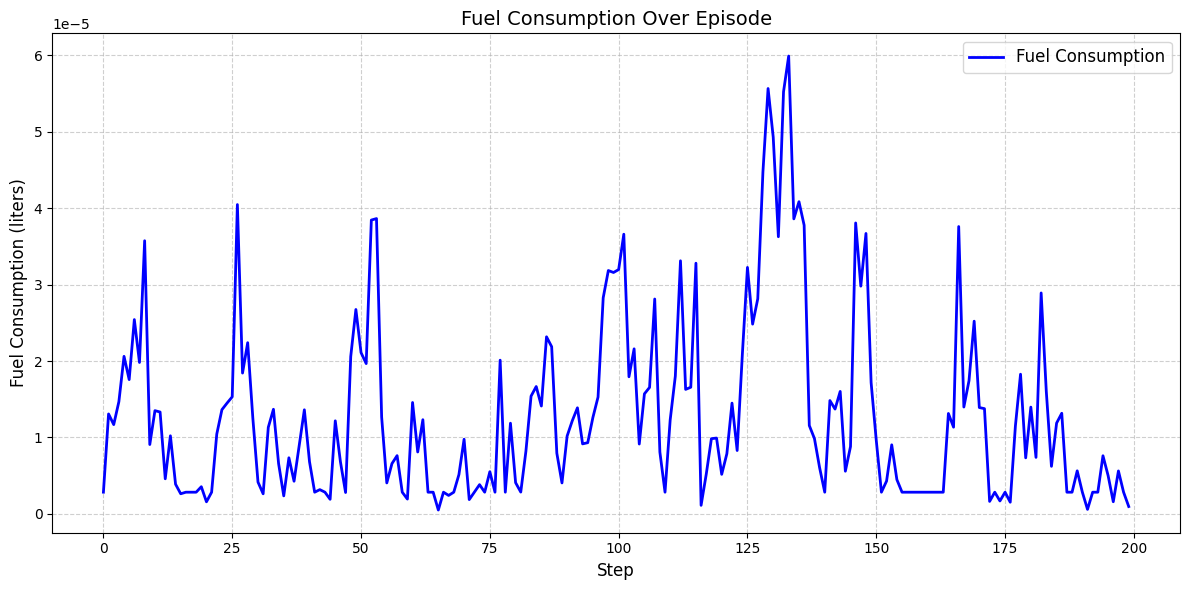

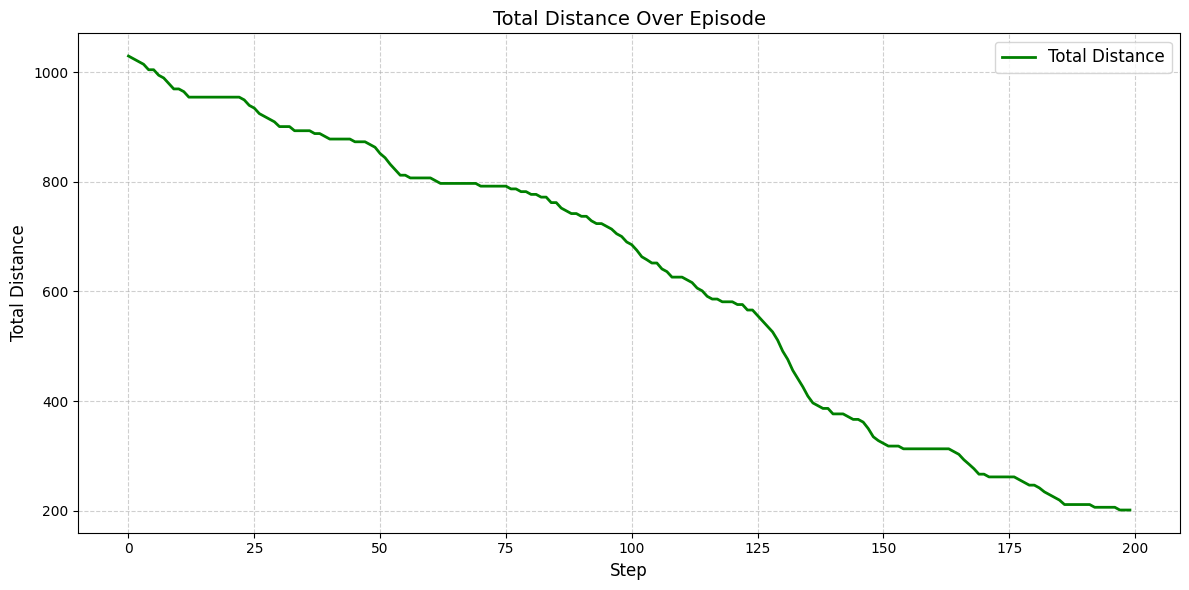

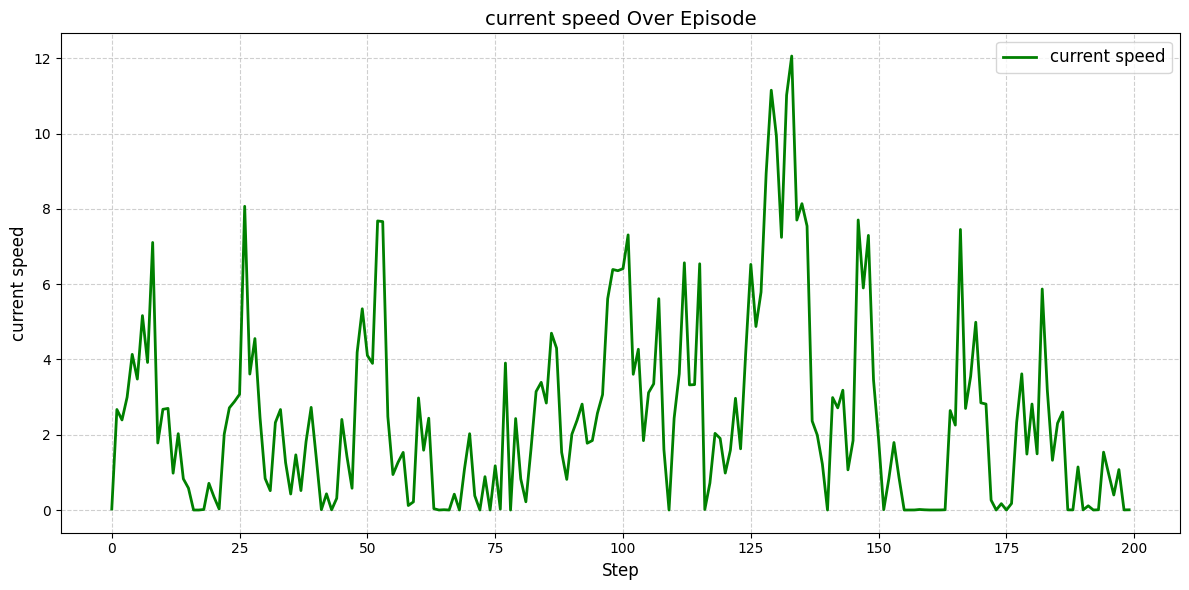

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 559 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 572 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 551 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 580 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 582 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 559, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 572, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 551, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 580, موقعیت = Location(x=95.040001, y=12.560010, z=0.10326

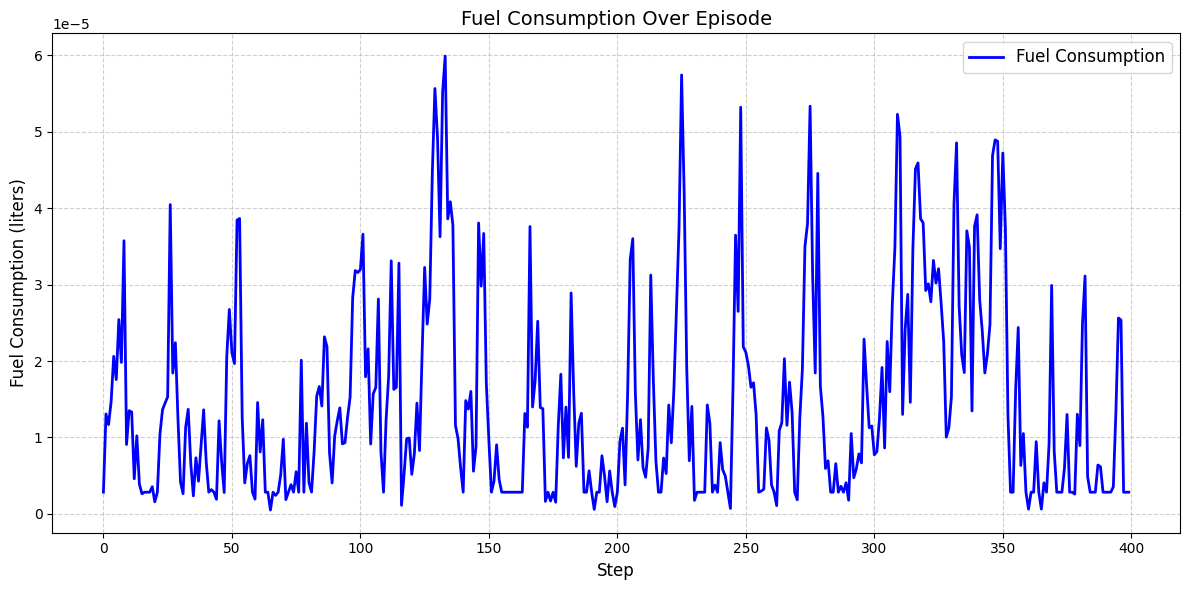

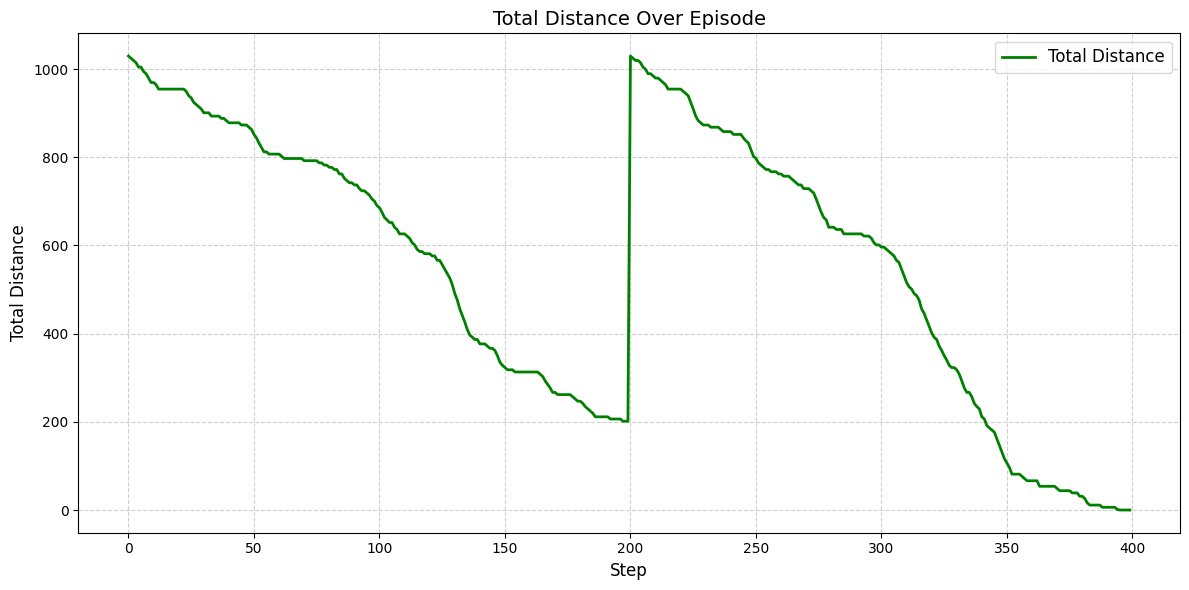

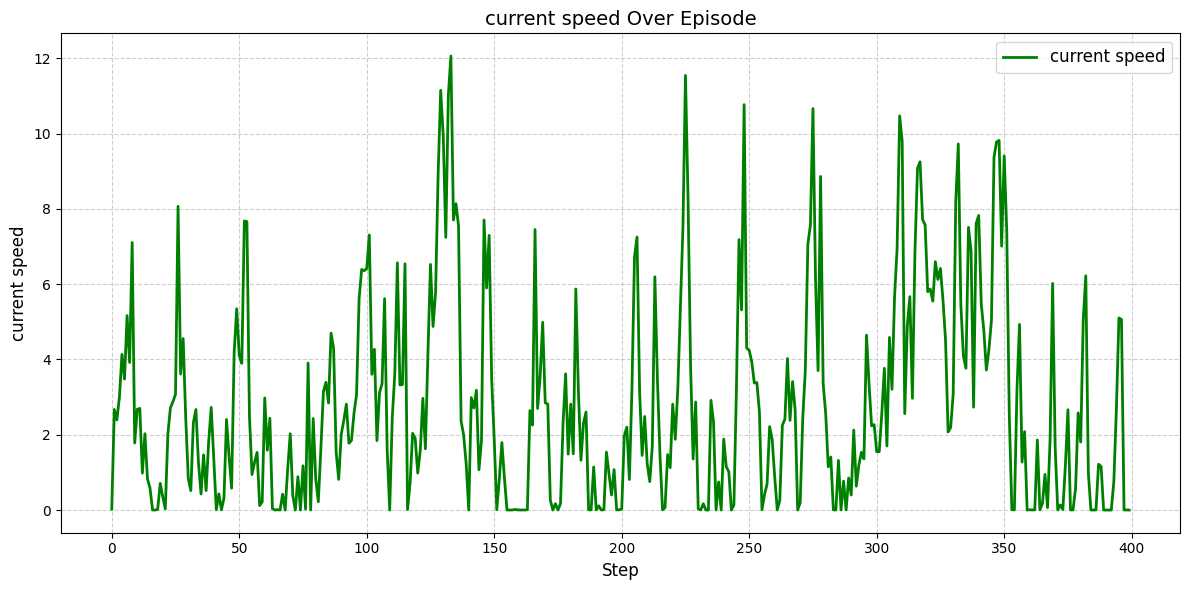

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 733 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 746 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 725 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 754 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 756 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 733, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 746, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 725, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 754, موقعیت = Location(x=95.040001, y=12.560010, z=0.10326

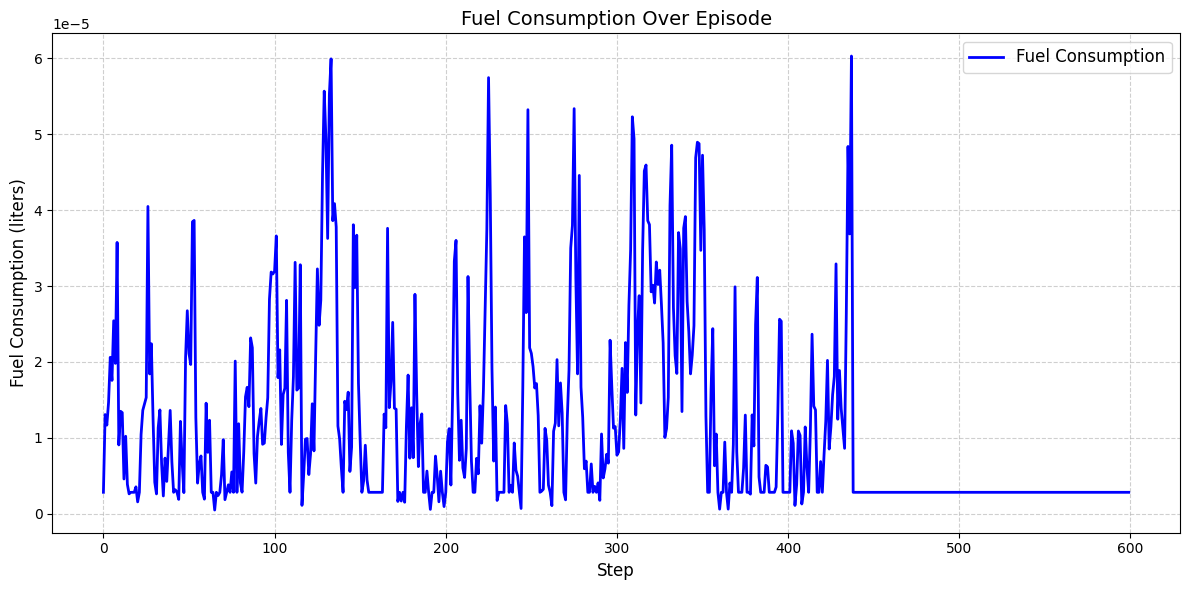

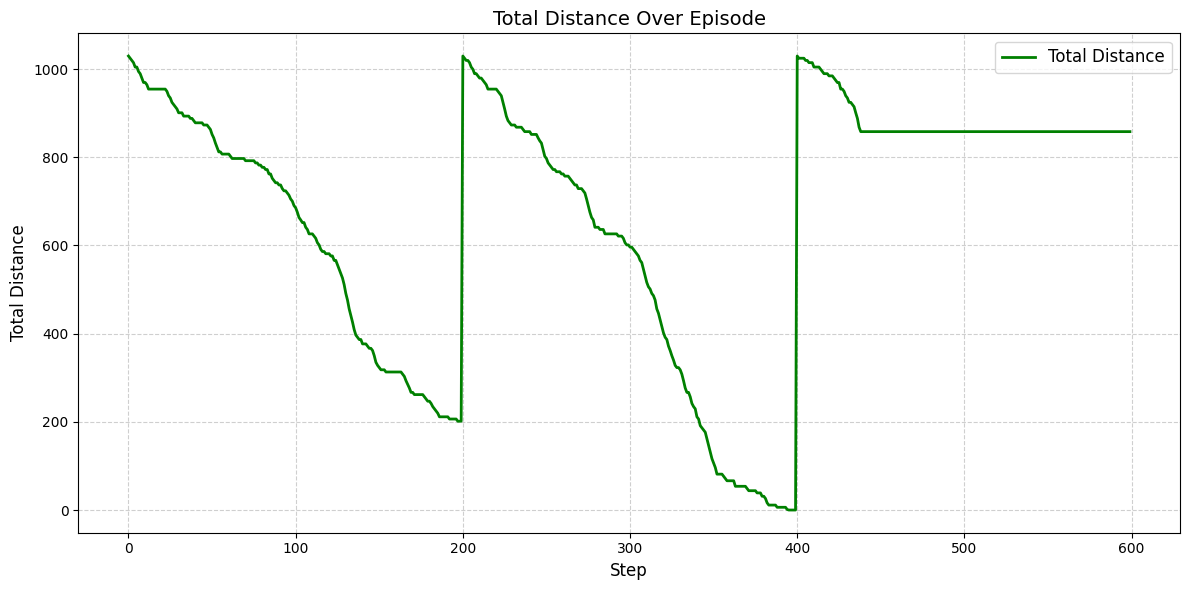

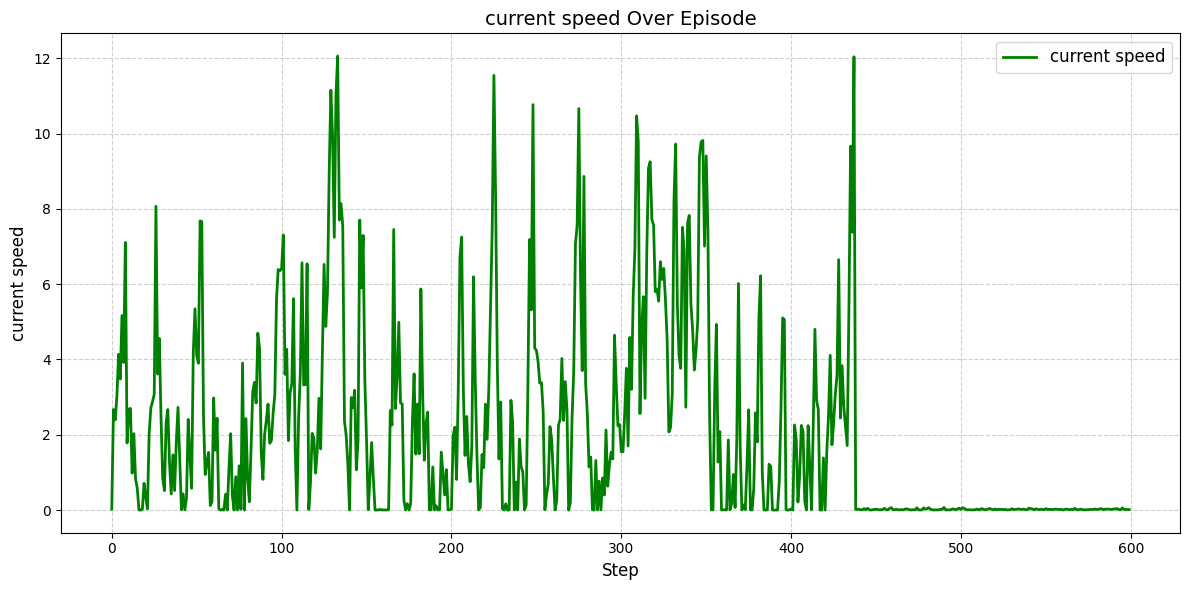

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 907 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 920 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 899 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 928 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 930 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 907, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 920, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 899, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 928, موقعیت = Location(x=95.040001, y=12.560010, z=0.10326

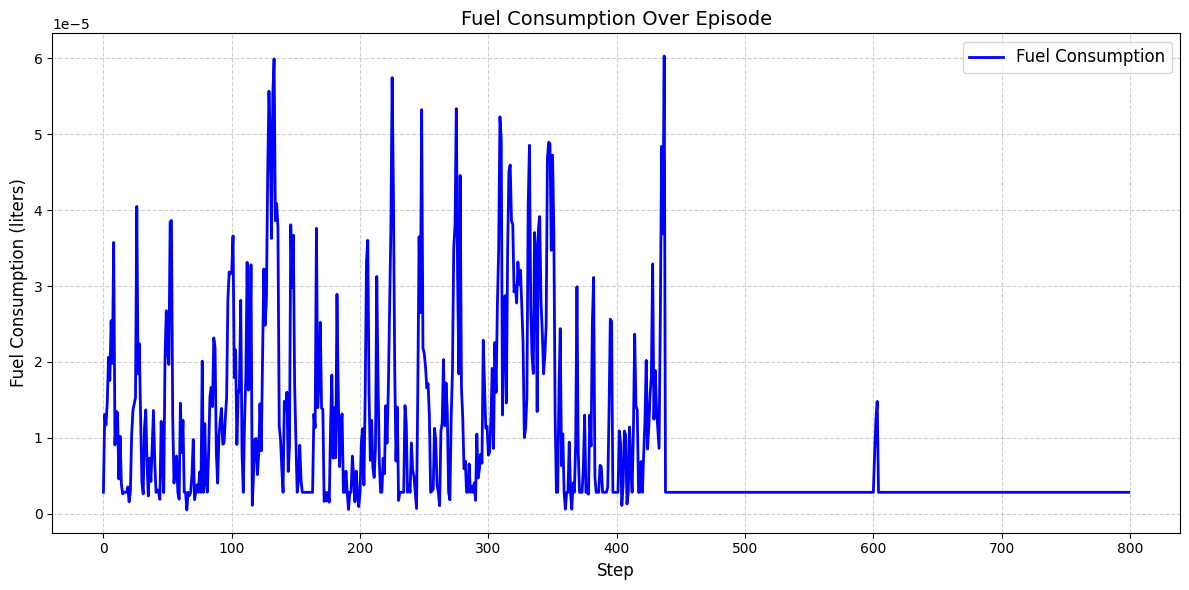

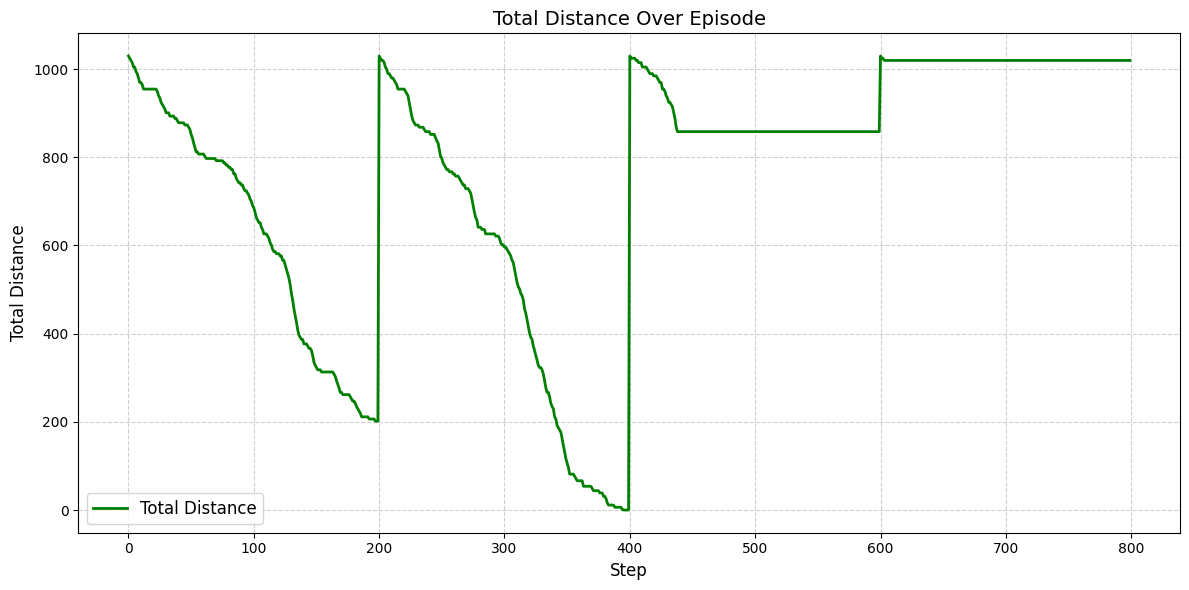

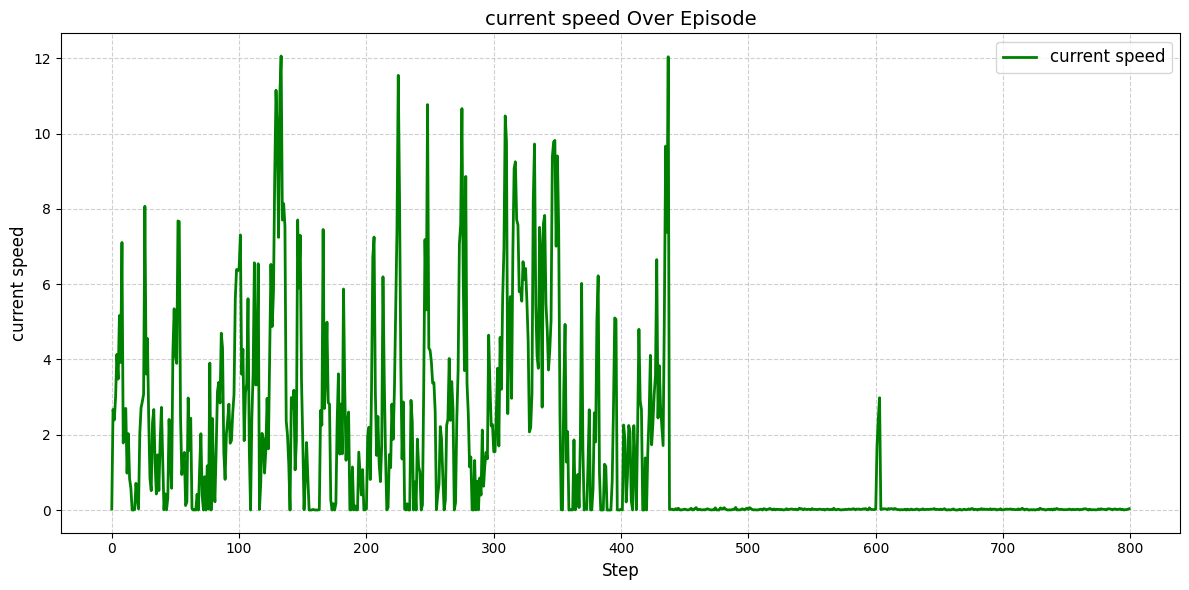

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 1081 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1094 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1073 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1102 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1104 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 1081, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 1094, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 1073, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 1102, موقعیت = Location(x=95.040001, y=12.560010, 

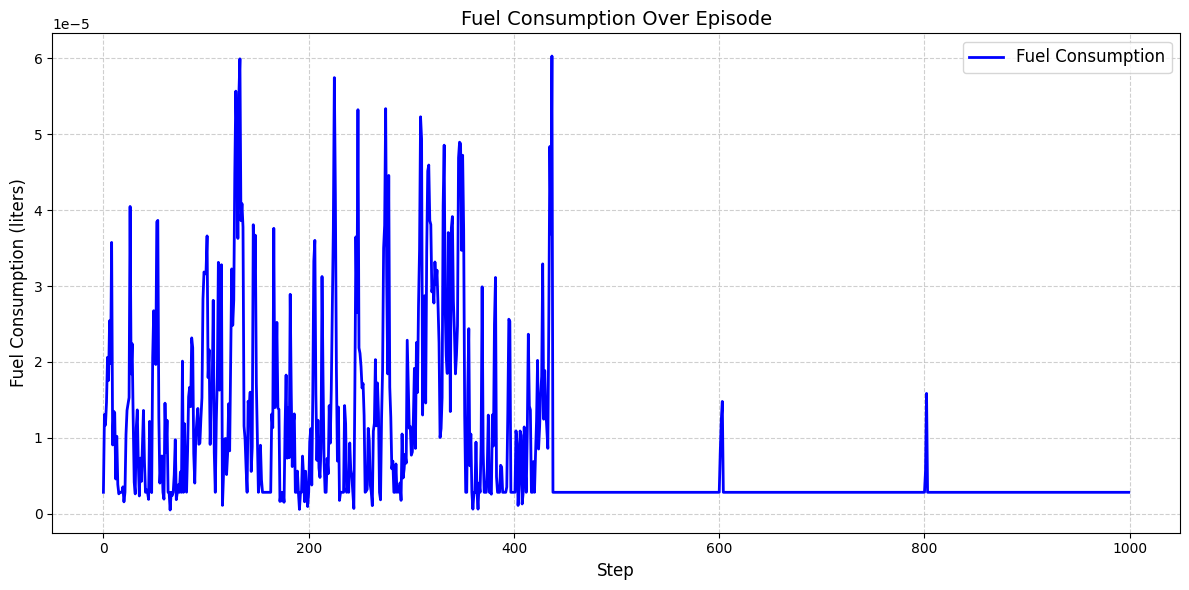

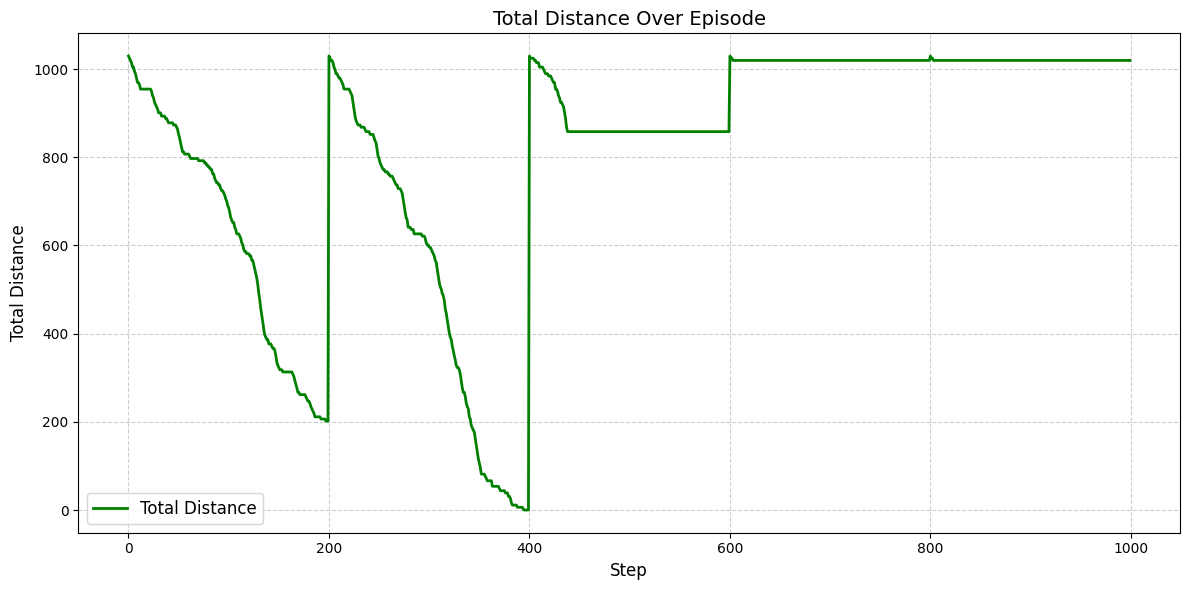

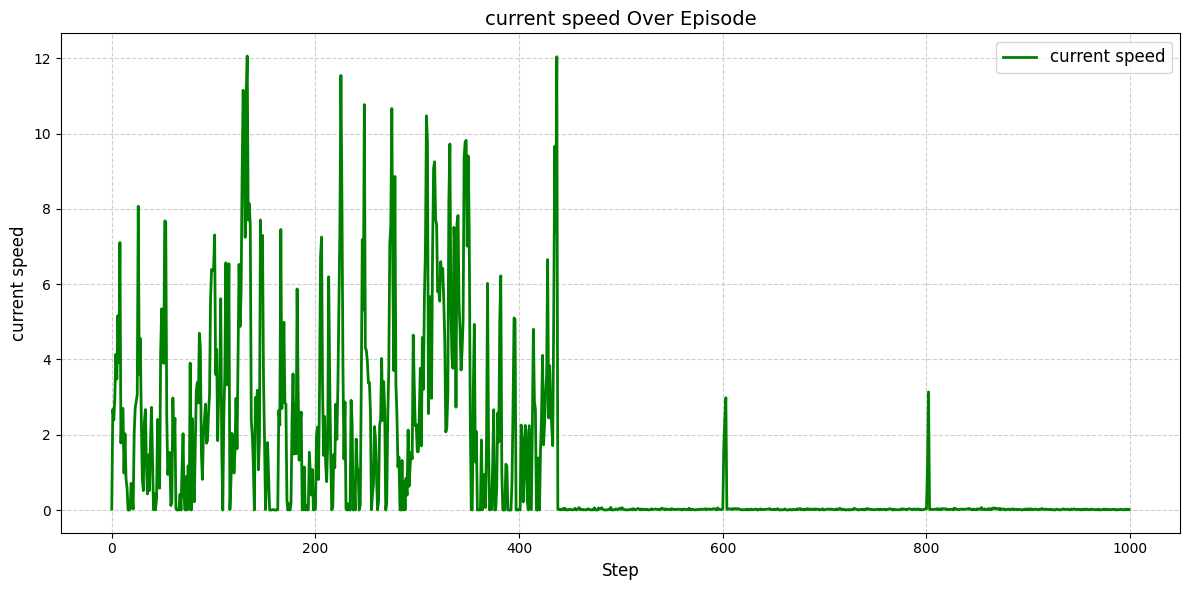

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 1255 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1268 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1247 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1276 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1278 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 1255, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 1268, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 1247, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 1276, موقعیت = Location(x=95.040001, y=12.560010, 

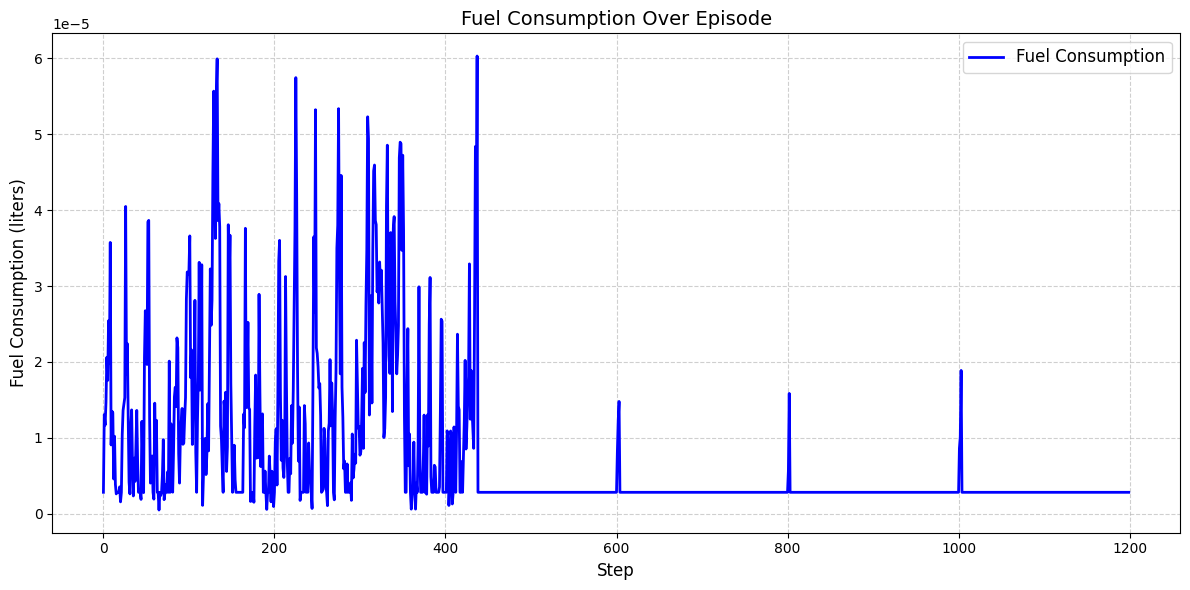

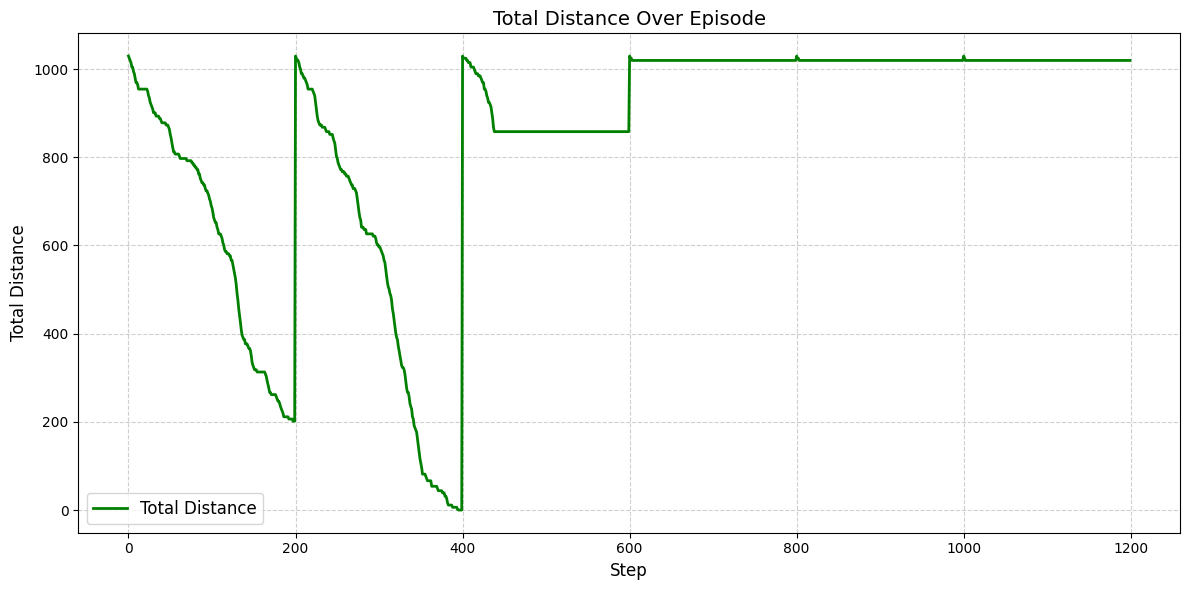

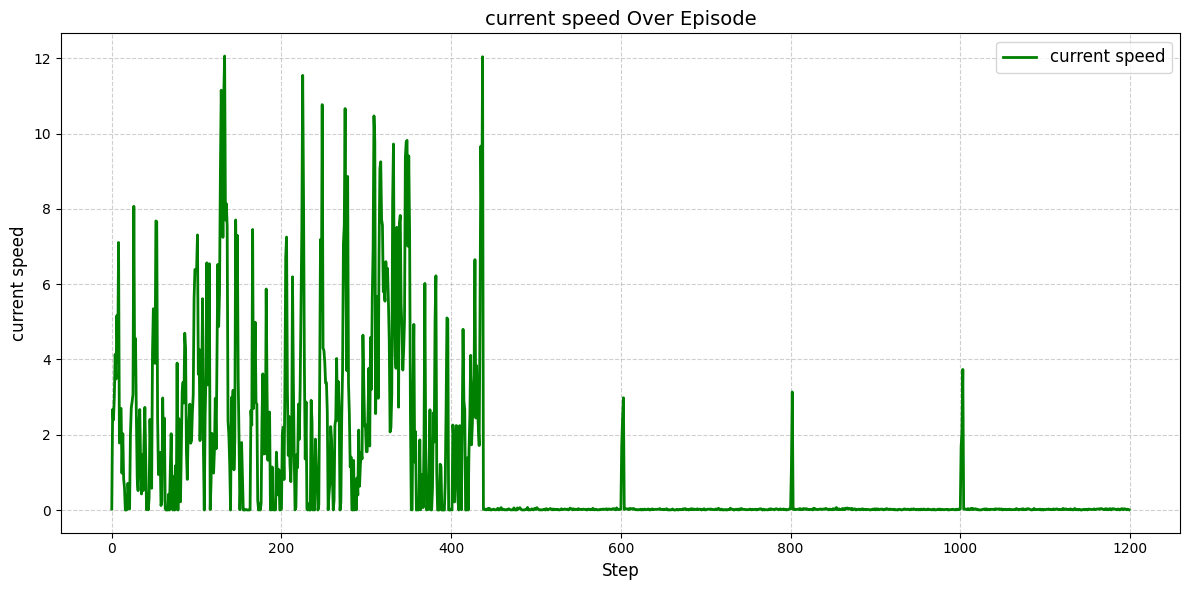

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 1429 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1442 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1421 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1450 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1452 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 1429, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 1442, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 1421, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 1450, موقعیت = Location(x=95.040001, y=12.560010, 

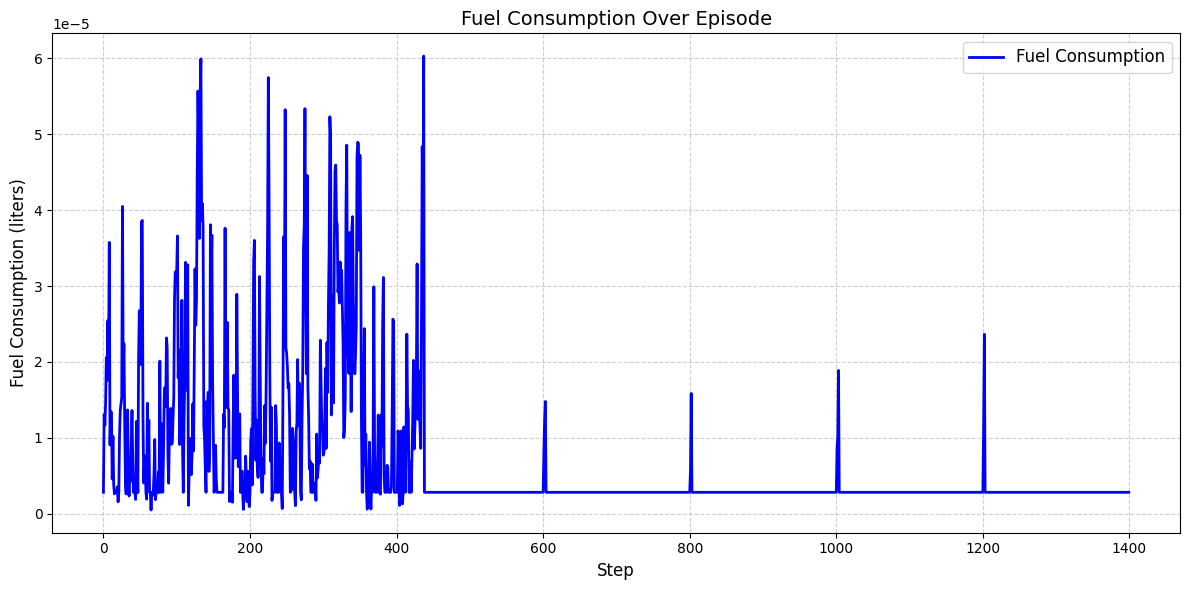

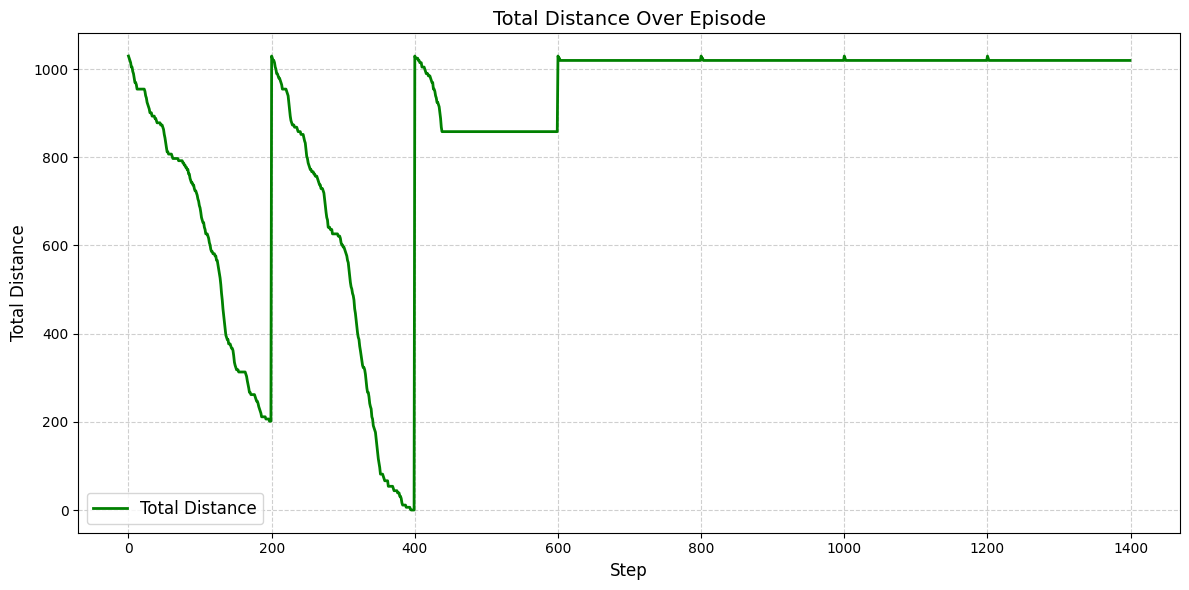

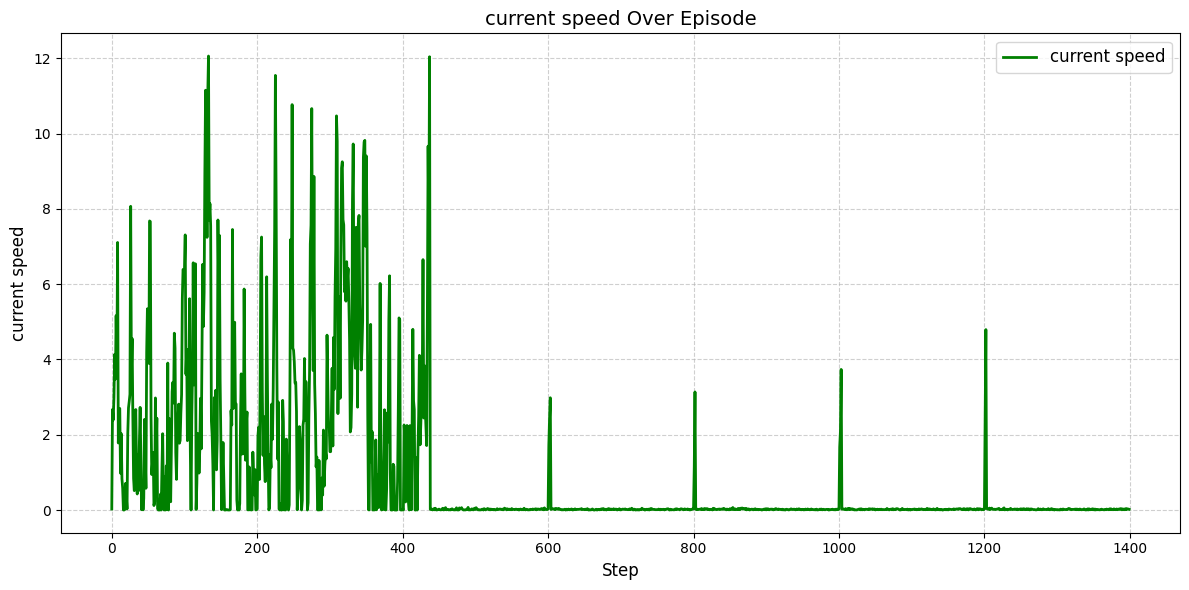

City: Town01, Start: Location(x=392.000000, y=184.000000, z=1.500000), End: Location(x=391.000000, y=37.000000, z=1.500000), Traffic Lights: 5
چراغ راهنمایی با شناسه 1603 نزدیک به مکان Location(x=351.000000, y=326.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1616 نزدیک به مکان Location(x=339.000000, y=147.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1595 نزدیک به مکان Location(x=105.000000, y=129.000000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1624 نزدیک به مکان Location(x=92.000000, y=15.700000, z=0.190000) پیدا شد.
چراغ راهنمایی با شناسه 1626 نزدیک به مکان Location(x=320.000000, y=2.000000, z=0.190000) پیدا شد.
Target speeds_1: [0.0, 0.0, 0.0, 0.0, 0.0]
چراغ شماره 1: ID = 1603, موقعیت = Location(x=349.600006, y=324.080078, z=0.103242)
چراغ شماره 2: ID = 1616, موقعیت = Location(x=341.250031, y=143.559952, z=0.104207)
چراغ شماره 3: ID = 1595, موقعیت = Location(x=102.719986, y=126.820015, z=0.103262)
چراغ شماره 4: ID = 1624, موقعیت = Location(x=95.040001, y=12.560010, 

KeyboardInterrupt: 

In [5]:
import sys
sys.path.append('C:\Carla\WindowsNoEditor\PythonAPI')
sys.path.append('C:\Carla\WindowsNoEditor\PythonAPI\carla')
sys.path.append('C:\Carla\WindowsNoEditor\PythonAPI\carla\agents')



import gymnasium as gym
import numpy as np
import carla
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.running_mean_std import RunningMeanStd
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import time
from stable_baselines3.common.policies import ActorCriticPolicy
import torch
from agents.navigation.global_route_planner import GlobalRoutePlanner
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import os







class FuelConsumptionModel:
    def __init__(self, fps=60):
        # تعداد فریم در ثانیه
        self.fps = fps

        # مصرف سوخت در حالت سکون (لیتر در هر گام شبیه‌سازی)
        self.idle_fuel_rate = 0.00017 / fps  # 0.0001667 لیتر در ثانیه تقسیم بر تعداد گام‌ها

        # عوامل مصرف سوخت در حرکت (بر اساس سرعت و شتاب در هر گام)
        self.speed_factor = 0.0003 / fps  # مصرف مرتبط با سرعت
        self.acceleration_factor = 0.0001 / fps  # مصرف مرتبط با شتاب

        # کل مصرف سوخت
        self.total_fuel_consumption = 0.0
    
    def calculate_fuel(self, speed, acceleration, is_idle=False):
        """
        محاسبه مصرف سوخت در یک گام شبیه‌سازی
        :param speed: سرعت خودرو (متر بر ثانیه)
        :param acceleration: شتاب خودرو (متر بر ثانیه مربع)
        :param is_idle: آیا خودرو در حالت سکون است
        :return: مصرف سوخت در این گام (لیتر)
        """
        if is_idle or speed < 0.1:  # اگر خودرو ایستاده است
            fuel_rate = self.idle_fuel_rate
        else:  # اگر خودرو در حرکت است
            fuel_rate = (speed * self.speed_factor) + (abs(acceleration) * self.acceleration_factor)
        
        # جمع‌کردن مصرف سوخت
        self.total_fuel_consumption += fuel_rate
        return fuel_rate
    
    def get_total_consumption(self):
        """
        دریافت کل مصرف سوخت
        """
        return self.total_fuel_consumption


class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def control(self, target, current):
        # محاسبه خطا
        error = target - current
        
        # انتگرال خطا برای بهبود دقت بلندمدت
        self.integral += error
        
        # مشتق خطا برای بهبود پاسخ‌دهی سریع
        derivative = error - self.prev_error
        self.prev_error = error
        
        # محاسبه خروجی کنترلر PID
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        return output


class CarlaEnv(gym.Env):
    def __init__(self, max_steps=20000, max_traffic_lights=5 ):
        super(CarlaEnv, self).__init__()
        self.max_steps = max_steps
        self.current_step = 0
        self.fuel_model = FuelConsumptionModel(fps=60)  # مدل مصرف سوخت
        self.last_distance_update_time = time.time()
        self.distance_to_current_light = 0.0  # ذخیره فاصله اولیه
        self.current_target_traffic_light = None  # چراغ هدف فعلی
        self.next_target_traffic_light = None  # چراغ هدف فعلی
        self.num_traffic_lights = 0 # اضافه کردن این خط
        self.current_light_index = 0
        self.last_light_index = 0
        #traffic_light_state = None
        self.remaining_time = 0  
        self.selected_city_route = None  # مقداردهی اولیه ویژگی
        self.max_traffic_lights = max_traffic_lights
        self.traffic_light_states = [0] * self.max_traffic_lights
         # ویژگی‌های فاصله
        self.distance_to_light_1 = 0.0
        self.final_distance = 0.0
        self.distance_between_lights_list = []
        self.total_distance = 0.0
        self.previous_distance = 0.0
        self.optimal_speed = 0.0
        self.target_speeds = [] # تعریف متغیر target_speeds
        self.total_distance_list = []
        self.last_action_throttle = 0.0
        self.last_action_brake = 0.0
        self.previous_speed = 0.0
        
      
        
        

        

        # اتصال به CARLA
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(45.0)
        self.world = self.client.get_world()
        self.map =self.world.get_map()
        self.vehicle = None

        # تنظیم حالت هم‌زمان
        self.settings = self.world.get_settings()
        self.settings.synchronous_mode = True  # فعال کردن حالت هم‌زمان
        self.settings.fixed_delta_seconds = 1.0 / 60  # تنظیم نرخ فریم ثابت به 100
        self.world.apply_settings(self.settings)
        
        # تعریف کنترلرهای PID برای throttle و steer
        self.pid_throttle = PIDController(Kp=1.5, Ki=0.02, Kd=0.05)  # تنظیم پارامترهای PID برای throttle
        self.pid_steer = PIDController(Kp=0.5, Ki=0.01, Kd=0.1)  # تنظیم پارامترهای PID برای steer

        max_traffic_lights = 5
        self.action_space = gym.spaces.Box(
            low=np.array([0.0, -1.0, 0.0]),  # throttle, steer, brake
            high=np.array([1.0, 1.0, 1.0]),  # throttle, steer, brake
            dtype=np.float32
        )

        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(7,),  
            dtype=np.float32
        )
        print(f"Observation space shape: {self.observation_space.shape}")
        print(f"self.action_space: {self.action_space}")
        
        
       
       
        
        



         # تعریف مسیرهای مختلف برای شهرها
        self.city_routes = {
            "Town01": [
                {
                    "start": carla.Location(x=392, y=184, z=1.5),
                    "end": carla.Location(x=391, y=37, z=1.5),
                    "traffic_lights": [
                        carla.Location(x=351, y=326, z=0.19),
                        carla.Location(x=339, y=147, z=0.19),
                        carla.Location(x=105, y=129, z=0.19),
                        carla.Location(x=92, y=20, z=0.19),
                        carla.Location(x=320, y=2, z=0.19)
                    ],
                    "traffic_detection_points": [  # نقاط جداگانه برای شناسایی چراغ‌ها
                        carla.Location(x=351, y=326, z=0.19),
                        carla.Location(x=339, y=147, z=0.19),
                        carla.Location(x=105, y=129, z=0.19),
                        carla.Location(x=92, y=15.7, z=0.19),
                        carla.Location(x=320, y=2, z=0.19)]
                }
            ]
        }
            
            
            
        
       
       
       

    def set_traffic_light_time(self, traffic_light_setting):
        actor_list = self.world.get_actors().filter('traffic.traffic_light')
        # غیرفعال کردن حالت هم‌زمان
        self.settings.synchronous_mode = False
        self.world.apply_settings(self.settings)
        for actor in actor_list:
            if isinstance(actor, carla.TrafficLight):
                actor.set_state(carla.TrafficLightState.Green) # اطمینان از تنظیم چراغ به وضعیت سبز قبل از تنظیم زمان‌ها 
                actor.set_red_time(traffic_light_setting["red_time"])
                actor.set_green_time(traffic_light_setting["green_time"])
                actor.set_yellow_time(traffic_light_setting["yellow_time"])
                # بررسی تغییرات پس از مدتی
        # فعال کردن حالت هم‌زمان 
        self.settings.synchronous_mode = True
        self.settings.fixed_delta_seconds = 1.0 / 60  # تنظیم نرخ فریم ثابت به 100
        self.world.apply_settings(self.settings)
        
       
    
    def get_traffic_light_states(self):
        return self._traffic_light_states

       
    def select_random_city_route(self):
        #selected_city = random.choice(list(self.city_routes.keys()))
        selected_city = "Town01"
        selected_route = random.choice(self.city_routes[selected_city])
        self.world = self.client.load_world(selected_city)
        self.map = self.world.get_map()
        self.settings = self.world.get_settings()
        self.start_location = selected_route["start"]
        self.end_location = selected_route["end"]
        self.traffic_light_locations = selected_route["traffic_lights"]
         # نقاط جدید برای شناسایی چراغ‌ها
        self.traffic_detection_points = selected_route.get("traffic_detection_points", [])
    
        print(f"City: {selected_city}, Start: {self.start_location}, End: {self.end_location}, "
              f"Traffic Lights: {len(self.traffic_light_locations)}")


    def create_observation(self):
        
        current_speed = self.get_speed()
        target_speed = self.target_speeds[self.current_light_index]
       
    
        variables = [
            current_speed,
            target_speed,
            self.total_distance,  # کل مسافت باقی‌مانده
            self.distance_to_current_light,  # فاصله تا چراغ راهنمایی فعلی
            self.last_traffic_light_state,  # وضعیت آخرین چراغ
            self.remaining_time,  # زمان باقی‌مانده برای تغییر وضعیت چراغ
            self.fuel_model.get_total_consumption(),  # 🔥 اضافه کردن مصرف سوخت به فضای مشاهده
            ]
        obs = np.array(variables, dtype=np.float32)
        """
        obs = np.array(variables, dtype=np.float32).reshape(-1, 1)
    
        # استفاده از StandardScaler به جای MinMaxScaler
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(obs)
    
       
    
        obs = features_scaled.flatten().astype(np.float32)
    
        
        """
        # چاپ مقادیر نرمال‌سازی شده
        #print("مقادیر نرمال‌سازی شده:")
        #for idx, feature in enumerate(obs):
            #print(f"Feature {idx+1}: {feature:.4f}")
      
        return obs

    def get_time_to_change(self, light, cycle_times):
        elapsed_time = light.get_elapsed_time()  # زمان سپری‌شده در وضعیت فعلی
        if light.state == carla.TrafficLightState.Green:
            return cycle_times["green"] - elapsed_time
        elif light.state == carla.TrafficLightState.Yellow:
            return cycle_times["yellow"] - elapsed_time
        elif light.state == carla.TrafficLightState.Red:
            return cycle_times["red"] - elapsed_time
        else:
            return 0




    def calculate_optimal_speed(self, distance_to_light, light_state, time_to_change, cycle_times):
        """
        محاسبهٔ سرعت هدف برای رسیدن به چراغ با کمترین توقف احتمالی.
        در این روش:
          - اگر عامل در بازهٔ سبز یا زرد برسد، زمان انتظار = 0.
          - اگر در بازهٔ قرمز برسد، باید تا انتهای چرخه صبر کند.
          - در نهایت سرعتی انتخاب می‌شود که (ETA + waiting_time) کمترین مقدار باشد.
        """
        min_speed = 5  # حداقل سرعت بهینه (متر بر ثانیه)
        max_speed = 10  # حداکثر سرعت بهینه (متر بر ثانیه)
        absolute_max_speed = 30.0  # حداکثر سرعت مجاز خودرو (متر بر ثانیه) - در اینجا صرفاً برای اطلاع
    
        # بررسی‌های اولیه
        if distance_to_light <= 0:
            print("Invalid distance to light. Returning minimum speed.")
            return min_speed
    
        if time_to_change < 0:
            print("Invalid time to change. Returning minimum speed.")
            return min_speed
    
        # چرخهٔ کامل چراغ
        green_time = cycle_times["green"]   # مثلاً 10 ثانیه
        yellow_time = cycle_times["yellow"] # مثلاً 3 ثانیه
        red_time = cycle_times["red"]       # مثلاً 30 ثانیه
        cycle_time = green_time + yellow_time + red_time  # مجموع = 43
    
        best_speed = min_speed
        best_total_time = float('inf')
    
        # گام جست‌وجوی سرعت (اینجا 1 متر/ثانیه؛ می‌توانید ریزتر یا درشت‌تر کنید)
        speed_step = 1
    
        # جست‌وجو در بازه [min_speed .. max_speed]
        for speed in range(int(min_speed), int(max_speed) + 1, speed_step):
            # زمان رسیدن به چراغ با این سرعت
            eta = distance_to_light / speed  # Estimated Time of Arrival
    
            # محاسبهٔ لحظهٔ رسیدن در چرخه
            time_at_arrival = (time_to_change + eta) % cycle_time
    
            # اگر در محدودهٔ سبز یا زرد برسیم، انتظار = 0
            if time_at_arrival <= (green_time + yellow_time):
                waiting_time = 0.0
            else:
                # در بازهٔ قرمز
                waiting_time = cycle_time - time_at_arrival
    
            # زمان کل (رانندگی + توقف)
            total_time = eta + waiting_time
    
            # به‌روزرسانی بهترین سرعت در صورت بهبود
            if total_time < best_total_time:
                best_total_time = total_time
                best_speed = speed
    
        # اگر به هر دلیل هیچ سرعت مناسبی پیدا نشد (در عمل نباید بیفتد)
        if best_total_time == float('inf'):
            print(f"No optimal speed found for distance: {distance_to_light}, light state: {light_state}")
            return min_speed
    
        return best_speed

    

    def calculate_current_target_speed(self):
        """
        کد قبلی شما که فقط با فراخوانی تابع calculate_optimal_speed، مقدار target_speed را تنظیم می‌کند
        """
        if self.current_light_index < len(self.target_traffic_lights):
            current_light = self.target_traffic_lights[self.current_light_index]
            distance_to_light = self.distance_to_current_light
            light_state = current_light.state
    
            cycle_times = {"green": 10, "yellow": 3, "red": 30}
            time_to_change = self.get_time_to_change(current_light, cycle_times)
    
            # اینجا فقط همان تابع جدید را صدا بزنید
            target_speed = self.calculate_optimal_speed(
                distance_to_light, light_state, time_to_change, cycle_times
            )
    
            self.target_speeds[self.current_light_index] = target_speed
        else:
            print(f"Invalid light index: {self.current_light_index}. No target speed calculated.")
    
        
        
     
    # تابع برای محاسبه فاصله تجمعی بین چراغ‌ها
    def calculate_distance_to_light(self, waypoints, vehicle_location):
        
        #محاسبه فاصله تجمعی بین موقعیت فعلی خودرو و چراغ مشخص‌شده
        
        # تبدیل لیست تودرتو به لیست تخت
        if len(waypoints) > 0 and isinstance(waypoints[0], list):
            waypoints = [wp for sublist in waypoints for wp in sublist]

        total_distance = 0.0
        for i in range(len(waypoints)):
            wp = waypoints[i].transform.location
            if i == 0:
                # فاصله بین خودرو و اولین وی‌پوینت
                total_distance += vehicle_location.distance(wp)
            else:
                # فاصله بین وی‌پوینت‌های مسیر
                prev_wp = waypoints[i - 1].transform.location
                total_distance += prev_wp.distance(wp)
        return total_distance
  

    def calculate_total_distance(self, waypoints):
        """
        محاسبه فاصله تجمعی بین تمام وی‌پوینت‌های موجود در مسیر.
        """

        # تبدیل لیست تودرتو به لیست تخت
        if len(waypoints) > 0 and isinstance(waypoints[0], list):
            waypoints = [wp for sublist in waypoints for wp in sublist]


        
        #print("Type of first element in waypoints:", type(waypoints[0]) if len(waypoints) > 0 else "Empty list")

        total_distance = 0.0
        for i in range(len(waypoints) - 1):
            wp1 = waypoints[i].transform.location
            wp2 = waypoints[i + 1].transform.location
            total_distance += wp1.distance(wp2)
        return total_distance
                                                                    

    def extract_route(self, start_location, end_location):
        grp = GlobalRoutePlanner(self.map, sampling_resolution=5)
        start_waypoint = self.map.get_waypoint(start_location, project_to_road=True)
        end_waypoint = self.map.get_waypoint(end_location, project_to_road=True)

        route = grp.trace_route(start_waypoint.transform.location, end_waypoint.transform.location)
        waypoints = []
        previous_waypoint = None
    
        # محاسبه فاصله بین وی‌پوینت‌ها و فیلتر کردن آن‌ها
        for waypoint, road_option in route:
            if previous_waypoint is None:
                waypoints.append(waypoint)
                previous_waypoint = waypoint
            else:
                distance = previous_waypoint.transform.location.distance(waypoint.transform.location)
                if distance >= 5:
                    waypoints.append(waypoint)
                    previous_waypoint = waypoint

        # رسم مسیر A* برای بررسی
        for waypoint in waypoints:
            self.world.debug.draw_point(
                waypoint.transform.location, size=0.1, color=carla.Color(0, 255, 0), life_time=0.0
            )
    
        return waypoints


    def find_target_traffic_light_ids(self, target_locations, radius=10):
        """
        پیدا کردن شناسه‌های چراغ‌های راهنمایی نزدیک به مکان‌های مشخص شده
        """
        target_ids = []
        for location in target_locations:
            for actor in self.world.get_actors().filter('traffic.traffic_light'):
                if actor.get_location().distance(location) < radius:
                    target_ids.append(actor.id)
                    print(f"چراغ راهنمایی با شناسه {actor.id} نزدیک به مکان {location} پیدا شد.")
        self.num_traffic_lights = len(target_ids)
        self.last_light_index = self.num_traffic_lights 
        return target_ids



    def update_target_traffic_light(self):
        """
        به‌روزرسانی وضعیت چراغ هدف و مقداردهی remaining_time.
        """
        if not self.current_target_traffic_light:
            if self.num_traffic_lights > 0:
                print("هیچ چراغ هدفی تنظیم نشده است.")
            self.remaining_time = 0.0  # مقداردهی پیش‌فرض
            return None
    
        # دریافت وضعیت چراغ هدف از CARLA
        traffic_light_state = self.current_target_traffic_light.get_state()
    
        # اگر وضعیت چراغ تغییر کرده است
        if hasattr(self, 'last_traffic_light_state'):
            if self.last_traffic_light_state != traffic_light_state:
                print(f"تغییر وضعیت چراغ: {traffic_light_state.name}")
    
                # مقداردهی remaining_time بر اساس وضعیت چراغ
                if traffic_light_state == carla.TrafficLightState.Red:
                    self.remaining_time = self.red_duration
                elif traffic_light_state == carla.TrafficLightState.Green:
                    self.remaining_time = self.green_duration
                elif traffic_light_state == carla.TrafficLightState.Yellow:
                    self.remaining_time = self.yellow_duration

        

        # به‌روزرسانی وضعیت قبلی
        self.last_traffic_light_state = traffic_light_state

        # اطمینان از مقداردهی remaining_time
        if self.remaining_time is None:
            self.remaining_time = 0.0

        return traffic_light_state




    
    def setup_traffic_light_durations(self):
        
        # دریافت نام شهر فعلی
        #current_map_name = self.world.get_map().name  # مثلاً 'Carla/Maps/Town03'
    
        #if 'Town03' in current_map_name:
            #self.red_duration = 45.0  # زمان چراغ قرمز برای شهر ۳
        #else:
            #self.red_duration = 33.0  # زمان چراغ قرمز برای سایر شهرها
        self.red_duration = 30.0
        self.green_duration = 10.0  # زمان چراغ سبز ثابت
        self.yellow_duration = 3.0  # زمان چراغ زرد ثابت
    
        
    

       
    def spawn_vehicle(self):
            """
            ایجاد خودرو در نقطه شروع مسیر
            """
            blueprint_library = self.world.get_blueprint_library()
            vehicle_bp = blueprint_library.filter('vehicle')[0]
        
            # استفاده از اولین ویپوینت برای قرار دادن وسیله نقلیه
            spawn_point = self.waypoints[self.current_waypoint_index].transform
            #print(f"Spawning vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f}, {spawn_point.location.z:.2f})")  # دیباگ محل اسپاون خودرو
            self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)

            # بررسی اینکه آیا خودرو به درستی اسپاون شده است یا خیر
            if self.vehicle is None:
                print("Failed to spawn vehicle!")
            else:
                print("Vehicle spawned successfully!")

                # صبر برای به‌روزرسانی شبیه‌ساز
                self.world.tick()
                time.sleep(0.1)  # کمی صبر کنید تا شبیه‌ساز موقعیت را به‌روزرسانی کند

                # چاپ موقعیت به‌روزرسانی شده خودرو
                vehicle_location = self.vehicle.get_transform().location
                #print(f"Updated Vehicle Location: ({vehicle_location.x:.2f}, {vehicle_location.y:.2f}, {vehicle_location.z:.2f})")



    # پس از پایان تست مدل
    def after_model_test(self):
        # غیرفعال کردن حالت هم‌زمان و نرخ فریم ثابت برای بازگشت شبیه‌ساز به حالت عادی
        self.settings = self.world.get_settings()
        self.settings.synchronous_mode = False  # غیرفعال کردن حالت هم‌زمان
        self.settings.fixed_delta_seconds = None  # غیرفعال کردن نرخ فریم ثابت
        self.world.apply_settings(self.settings)

        # در صورت نیاز، خودرو را تخریب کنید
        if self.vehicle:
            try:
                self.vehicle.destroy()
            except:
                print("Error destroying vehicle after model test")
    
        # در صورت نیاز می‌توانید شبیه‌ساز را خاموش یا متوقف کنید
        print("Model test finished, CARLA settings returned to normal.")


    def get_speed(self):
        """
        دریافت سرعت خودرو
        """
        velocity = self.vehicle.get_velocity()
        speed = np.linalg.norm(np.array([velocity.x, velocity.y, velocity.z]))
        return speed


    
    def get_distance_to_waypoint(self):
        """
        محاسبه فاصله خودرو تا ویپوینت فعلی
        """
        vehicle_location = self.vehicle.get_location()
        waypoint_location = self.waypoints[self.current_waypoint_index].transform.location
        return vehicle_location.distance(waypoint_location)

    def get_steer_to_waypoint(self):
        """محاسبه زاویه فرمان مورد نیاز برای رسیدن به ویپوینت بعدی"""
        vehicle_transform = self.vehicle.get_transform()
        vehicle_location = vehicle_transform.location
        waypoint_location = self.waypoints[self.current_waypoint_index].transform.location

        # محاسبه بردارهای مکان و زاویه بین خودرو و ویپوینت
        direction_vector = np.array([waypoint_location.x - vehicle_location.x, waypoint_location.y - vehicle_location.y])
        vehicle_forward_vector = np.array([vehicle_transform.rotation.get_forward_vector().x, vehicle_transform.rotation.get_forward_vector().y])

        # زاویه بین دو بردار
        angle = np.arctan2(direction_vector[1], direction_vector[0]) - np.arctan2(vehicle_forward_vector[1], vehicle_forward_vector[0])
         # محدود کردن زاویه به محدوده [-180, 180]
        angle = np.degrees(angle)
        if angle > 180:
            angle -= 360
        elif angle < -180:
            angle += 360
    
        return np.radians(angle)  # برگرداندن زاویه به رادیان

    def get_steer_to_next_waypoint(self):
        """
        محاسبه زاویه فرمان به سمت ویپوینت بعدی
        """
        if self.current_waypoint_index + 1 < len(self.waypoints):
            next_waypoint = self.waypoints[self.current_waypoint_index + 1].transform.location  # استخراج مختصات ویپوینت
            vehicle_location = self.vehicle.get_location()
        
            # تبدیل مختصات به آرایه عددی
            direction_vector = np.array([next_waypoint.x, next_waypoint.y]) - np.array([vehicle_location.x, vehicle_location.y])
        
            # محاسبه زاویه فرمان
            steer_angle = np.arctan2(direction_vector[1], direction_vector[0]) - np.radians(self.vehicle.get_transform().rotation.yaw)

            return np.clip(steer_angle, -np.pi, np.pi)  # محدود کردن زاویه به بازه معتبر
        else:
            return 0.0  # اگر ویپوینت بعدی وجود ندارد

         
    
    def step(self, action):
        """
        انجام یک گام در محیط
        """
        # دریافت سرعت فعلی
        current_speed = self.get_speed()
        # مقدار پیش‌فرض برای brake
        throttle = 0.0  # مقدار پیش‌فرض
        brake = 0.0
        #steer = 0.0
        done = False  # مقدار پیش‌فرض برای done
        reward = 0.0  # پاداش اولیه صفر
        truncated = False
        fps_s = 1/60
        
        
        # به‌روزرسانی سرعت‌های هدف پس از عبور از هر چراغ
        #if self.current_light_index < len(self.target_traffic_lights):
        self.calculate_current_target_speed()
        target_speed = self.target_speeds[self.current_light_index]
            #print(f"Updated target speed for light {self.current_light_index + 1}: {target_speed} m/s")


       
         # افزودن لیست برای ذخیره مقادیر action و feul
        if not hasattr(self, 'fuel_consumption_log'):
            self.fuel_consumption_log = []

        # افزودن لیست برای ذخیره مقادیر total_distance
        if not hasattr(self, 'total_distance_log'):
            self.total_distance_log = []  # لیست برای ذخیره مقادیر total_distance

        #افزودن لیست برای ذخیره مقادیر سرعت لحظه ای
        # افزودن لیست برای ذخیره مقادیر action و throttle
        if not hasattr(self, 'get_speed_log'):
            self.get_speed_log = []
        

        # شتاب (در صورت موجود بودن)
        acceleration = self.get_acceleration() if hasattr(self, 'get_acceleration') else 0.0

        # آیا خودرو ایستاده است؟
        is_idle = current_speed < 0.1

        # محاسبه مصرف سوخت
        fuel_step = self.fuel_model.calculate_fuel(current_speed, acceleration, is_idle)

        # کاهش شمارش معکوس
        if hasattr(self, 'remaining_time') and self.remaining_time is not None:
            #print(f"Remaining Time: {self.remaining_time}, Delta Seconds: {self.settings.fixed_delta_seconds}")
            self.remaining_time -= fps_s
            self.remaining_time = max(0, self.remaining_time)
    
            if int(self.remaining_time + fps_s) != int(self.remaining_time):
                print(f"time remaining for  {self.last_traffic_light_state.name}: {self.remaining_time:.1f} ثانیه")

        # تنظیم زمان شروع
        if self.current_step == 0:
            self.start_time = time.time()
            self.last_distance_update_time = time.time()  # زمان آخرین به‌روزرسانی فاصله
            # محاسبه فاصله‌ها
            self.vehicle_location = self.vehicle.get_location()
            self.distance_to_light_1 = self.calculate_distance_to_light(self.route_to_light_1, self.vehicle_location)
            self.final_distance = self.calculate_total_distance(self.route_to_end)

        
        # وقتی خودرو از چراغ فعلی عبور می‌کند
        if self.current_target_traffic_light and self.distance_to_current_light <= 0:
            print(f"Passed Traffic Light {self.current_target_traffic_light.id}.")
            self.num_traffic_lights -= 1 # کاهش تعداد چراغ‌ها
            
            if len(self.target_traffic_light_ids) > 0:
                next_light_id = self.target_traffic_light_ids.pop(0)
                self.current_target_traffic_light = self.world.get_actor(next_light_id)
                print(f"چراغ جدید تنظیم شد: {self.current_target_traffic_light.id}")
                print(f"اخرین وضعیت چراغ جدید: {self.last_traffic_light_state}")
                #self.calculate_current_target_speed()  # محاسبه سرعت هدف برای چراغ جدید
                #target_speed = self.target_speeds[self.current_light_index]
                #print(f"Updated target speed for light {self.current_light_index + 1}: {target_speed} m/s")

                
               
            # استفاده از لیست فاصله‌ها
            #if len(self.distance_between_lights_list) > self.current_light_index and self.num_traffic_lights > 0:
            if self.current_light_index < self.last_light_index  and self.num_traffic_lights > 0:
                self.distance_to_current_light = self.distance_between_lights_list[self.current_light_index]  # مقدار فاصله فعلی
                 # استفاده از لیست فاصله‌ها برای فاصله بین چراغ فعلی و چراغ بعدی
                if self.distance_to_current_light == 0:
                    print("Zero distance detected, skipping to next light.")
                    
                # به‌روزرسانی شاخص برای چراغ بعدی
                self.current_light_index += 1 
                #print(f"تعداد ایندکس: {self.current_light_index}")
                
            else:
                # اگر چراغ دیگری باقی نمانده، فاصله تا مقصد نهایی
                self.distance_to_current_light = self.calculate_distance_to_light(
                    self.route_to_end, self.vehicle.get_location()
                )
                #print("No more traffic lights. Calculating distance to final destination.")
                print(f"Distance to Final Destination: {self.distance_to_current_light:.2f} meters")

        distance_to_waypoint = self.get_distance_to_waypoint()
    
        # محاسبه فرمان با استفاده از زاویه به ویپوینت فعلی
        steer_to_waypoint = self.get_steer_to_waypoint()  # زاویه به سمت ویپوینت
    
        # کنترل PID برای steer با استفاده از زاویه محاسبه شده
        current_steer = self.vehicle.get_control().steer

        # شرط برای بررسی ویپوینت‌های ابتدایی
        if self.current_waypoint_index < 3:
            # در ویپوینت‌های ابتدایی، فرمان به صورت دستی تنظیم شود یا کنترل PID محدود شود
            steer_control = 0.0  # مقدار ثابت فرمان برای ورود آرام به مسیر
            throttle = 0.5
            brake = 0.0
            
            #print(f"Skipping PID for first {self.current_waypoint_index + 1} waypoints.")
        else:
            # استفاده از کنترل PID برای ویپوینت‌های بعدی
            steer_control = self.pid_steer.control(steer_to_waypoint, current_steer)

        steer_control = np.clip(steer_control, -0.5, 0.5)  # محدود کردن زاویه فرمان
        steer = steer_control

       

      

        
        if self.current_step % 10 == 0:  # هر 10 گام یک بار مقدار گاز تغییر کند
            self.last_action_throttle = float(action[0])
            self.last_action_brake = float(action[2])  # action[2] برای brake

            
           
        
        throttle = self.last_action_throttle
        brake = self.last_action_brake 
    
        # مقدار خام throttle و brake را از عامل بگیر
        # مقدار پیش‌فرض throttle و brake


      
            
           


        
        
        # کنترل PID برای سرعت (throttle)
        current_speed = self.get_speed()

        if abs(steer_control) > 0.3:  # اگر زاویه فرمان بیشتر از مقدار خاص بود
            throttle = max(0.2, throttle)  # کاهش سرعت
        #throttle = np.clip(throttle, 0.0,1.0)

       

        # اگر به ویپوینت فعلی نزدیک شده‌ایم، به ویپوینت بعدی برویم
        if distance_to_waypoint < 5:
            # چاپ زاویه و واکنش فرمان زمانی که به ویپوینت می‌رسیم
            if self.current_waypoint_index + 1 < len(self.waypoints):
                # محاسبه زاویه بین خودرو و ویپوینت بعدی
                next_steer_to_waypoint = self.get_steer_to_waypoint()

                # کنترل PID برای فرمان با استفاده از زاویه به ویپوینت بعدی
                steer_control_for_next_wp = self.pid_steer.control(next_steer_to_waypoint, current_steer)
                steer_for_next_wp = np.clip(steer_control_for_next_wp, -0.3, 0.3)


       # بررسی تغییر وضعیت چراغ
        current_traffic_light_state = self.update_target_traffic_light()
        if current_traffic_light_state is not None :
            if self.last_traffic_light_state != current_traffic_light_state:
                print(f"تغییر وضعیت چراغ هدف: {current_traffic_light_state}")
                self.last_traffic_light_state = current_traffic_light_state

        
        
        # وقتی به وی‌پوینت فعلی نزدیک شدیم
        if distance_to_waypoint < 5:
            if self.current_waypoint_index < len(self.waypoints) - 1:
                previous_waypoint_index = self.current_waypoint_index
                self.current_waypoint_index += 1

                #print(f"throttle: {throttle:.2f} ")
                #print(f" brake: { brake:.2f} ")
                #print(f"target_speed: {target_speed:.2f} ")
                #print(f" current_speed: { current_speed:.2f} ")
                distance_step = self.waypoints[self.current_waypoint_index].transform.location.distance(
                        self.waypoints[previous_waypoint_index].transform.location)
                self.total_distance = max(0, self.total_distance - distance_step)
                
               
                if self.distance_to_current_light > 0 and self.num_traffic_lights > 0:
                    distance_step = self.waypoints[self.current_waypoint_index].transform.location.distance(
                        self.waypoints[previous_waypoint_index].transform.location
                    )
                    self.distance_to_current_light = max(0, self.distance_to_current_light - distance_step)
                    print(f"distance remainig to light : {self.distance_to_current_light:.2f} meters")
                    self.distance_to_light_1 = max(0, self.distance_to_light_1 - distance_step)
                    if self.distance_to_light_1 == 0:
                        self.distance_between_lights_list[self.current_light_index-1] = max(0, self.distance_between_lights_list[self.current_light_index-1] - distance_step)
                    
                    

                if self.distance_to_current_light > 0 and self.num_traffic_lights == 0:
                    distance_step = self.waypoints[self.current_waypoint_index].transform.location.distance(
                        self.waypoints[previous_waypoint_index].transform.location
                    )
                    self.distance_to_current_light = max(0, self.distance_to_current_light - distance_step)
                    print(f"distance to end: {self.distance_to_current_light:.2f} متر")
                    self.final_distance = max(0, self.final_distance - distance_step)
                    

            else:
                reward  += 10000  # پاداش برای رسیدن به مقصد
                print("arrive to distention")
                total_fuel = self.fuel_model.get_total_consumption()
                print(f"total fuel used : {total_fuel:.2f} liter")
                print(f"Episode finished with reward: {self.episode_reward}")
                done = True

        # Reset reward breakdown dictionary at the start of each episode
        if self.current_step == 0:
            self.reward_breakdown = {
                "Smooth Driving Reward": 0,
                "Harsh Speed Change Penalty": 0,
                "Red Light Obedience Reward": 0,
                "Red Light Violation Penalty": 0,
                "Smooth Stop at Light Red Reward": 0,
                "Harsh Braking Penalty Red": 0,
                "Harsh Braking Penalty" : 0,
                "Green Light Move Reward": 0,
                "Unnecessary Stop Penalty": 0,
                "Distance Reduction Reward": 0,
                "Throttle Stability Reward": 0,  # ✅ New
                "Throttle Instability Penalty": 0,  # ✅ New
                "Brake Stability Reward": 0,  # ✅ New
                "Brake Instability Penalty": 0,  # ✅ New
               
            }


        # Reward for smooth driving
        speed_change = abs(current_speed - self.previous_speed)
        if speed_change < 1.0:
            reward += 3
            self.reward_breakdown["Smooth Driving Reward"] += 3
        elif speed_change > 2.0:
            reward -= 3
            self.reward_breakdown["Harsh Speed Change Penalty"] -= 3

        # Enable traffic light learning only after 250,000 steps
        if self.current_step >= 5000:
            # Rewards and penalties for traffic light behavior
            traffic_light_state = self.update_target_traffic_light()
            
            if self.distance_to_current_light < 5:
                if traffic_light_state == carla.TrafficLightState.Red:
                    if self.get_speed() > 1.0:
                        reward -= 20
                        self.reward_breakdown["Red Light Violation Penalty"] -= 20
                    else:
                        reward += 10
                        self.reward_breakdown["Red Light Obedience Reward"] += 10
            
                elif traffic_light_state == carla.TrafficLightState.Green:
                    if self.get_speed() < 2.0:
                        reward -= 5
                        self.reward_breakdown["Unnecessary Stop Penalty"] -= 5
                    else:
                        reward += 5
                        self.reward_breakdown["Green Light Move Reward"] += 5
                        
            # Reward for smooth stop at red light
            if self.distance_to_current_light < 10 and traffic_light_state == carla.TrafficLightState.Red:
                if brake > 0 and self.get_speed() > 1.0:
                    reward -= 5
                    self.reward_breakdown["Harsh Braking Penalty Red"] -= 5
                elif self.get_speed() < 1.0:
                    reward += 5
                    self.reward_breakdown["Smooth Stop at Light Red Reward"] += 5

            
        # Penalty for harsh braking
        if brake > 0.8:
            reward -= 3
            self.reward_breakdown["Harsh Braking Penalty"] -= 3
        
        
        # Prevent sudden changes in throttle and brake
        throttle_change = abs(throttle - self.last_action_throttle)
        brake_change = abs(brake - self.last_action_brake)
        
        # Penalty for sudden throttle changes
        if throttle_change > 0.2:
            reward -= 2
            self.reward_breakdown["Throttle Instability Penalty"] -= 2
        else:
            reward += 2
            self.reward_breakdown["Throttle Stability Reward"] += 2
        
        # Penalty for sudden brake changes
        if brake_change > 0.2:
            reward -= 2
            self.reward_breakdown["Brake Instability Penalty"] -= 2
        else:
            reward += 2
            self.reward_breakdown["Brake Stability Reward"] += 2
        
        # Store last action values
        self.last_action_throttle = throttle
        self.last_action_brake = brake

      
        
       
       
                    
        if self.current_step % 20 == 0 :
            # پاداش برای کاهش فاصله به مقصد
            if self.total_distance < self.previous_total_distance:
                reward += 1  # کاهش فاصله به مقصد پاداش دارد
                self.reward_breakdown["Distance Reduction Reward"] += 2

         # Store the current distance for comparison in the next step
        self.previous_total_distance = self.total_distance

           
        # ذخیره سرعت قبلی برای مقایسه در گام بعدی
        self.previous_speed = current_speed    
            
        # ذخیره‌سازی فاصله‌های قبلی برای مقایسه در گام بعدی
        self.previous_distance_to_light_1 = self.distance_to_light_1
        self.previous_final_distance = self.final_distance
        self.previous_total_distance=self.total_distance

        # جمع‌آوری پاداش برای اپیزود 
        self.episode_reward += reward 

        # چاپ مقدار throttle و brake قبل از اعمال کنترل
        #print(f"Throttle_b: {throttle}, Steer_B: {steer}, Brake_B: {brake}")
        
        control = carla.VehicleControl(throttle=throttle, steer=steer, brake=brake)
        # چاپ مقادیر کنترل قبل از اعمال
        #print(f"Throttle: {throttle}, Steer: {steer}, Brake: {brake}")

        self.vehicle.apply_control(control)

       

        # اطلاعات اضافی، به عنوان یک دیکشنری خالی
        info = {}

        max_traffic_lights = 5  # تعریف تعداد حداکثر چراغ‌ها
        traffic_light_states = [0] * max_traffic_lights  # مقداردهی پیش‌فرض به چراغ‌ها
        traffic_light_times = [0] * max_traffic_lights  # لیست زمان باقی‌مانده برای هر چراغ


        # مقداردهی وضعیت چراغ‌ها بر اساس تعداد موجود
        for i, light in enumerate(self.target_traffic_lights[:max_traffic_lights]):
            if light.state == carla.TrafficLightState.Green:
                traffic_light_states[i] = 1
            elif light.state == carla.TrafficLightState.Yellow:
                traffic_light_states[i] = 2
            elif light.state == carla.TrafficLightState.Red:
                traffic_light_states[i] = 3
         # **چاپ اطلاعات برای بررسی**
        #print(f"Traffic light states: {traffic_light_states}")
        #print(f"Traffic light times: {traffic_light_times}")
                
        # اضافه کردن فاصله‌های جداگانه بین چراغ‌ها
        distance_between_lights_list = self.distance_between_lights_list[:max_traffic_lights]
        while len(self.distance_between_lights_list) < max_traffic_lights:
           self.distance_between_lights_list.append(0.0)  # پر کردن فاصله‌ها تا 5 مقدار
            
         # فضای مشاهده
        obs =np.array( [
            current_speed,
            target_speed,
            self.total_distance,  # کل مسافت باقی‌مانده
            self.distance_to_current_light,  # فاصله تا چراغ راهنمایی فعلی
            self.last_traffic_light_state,  # وضعیت آخرین چراغ
            self.remaining_time,  # زمان باقی‌مانده برای تغییر وضعیت چراغ
            self.fuel_model.get_total_consumption() ,  # 🔥 اضافه کردن مصرف سوخت به فضای مشاهده
            ], dtype=np.float32)
       
        self.current_step += 1
        if self.current_step % 1200 == 0:
            for idx, feature in enumerate(obs):
                print(f"Feature {idx+1}: {feature:.4f}")
    
            
        if self.current_step >= self.max_steps:
            done = True
            print(f"رسیدن به حداکثر گام. Distance to waypoint in the last step: {distance_to_waypoint:.2f} meters.")
            print(f"Episode finished with reward: {self.episode_reward}")
            total_fuel = self.fuel_model.get_total_consumption()
            print(f"کل مصرف سوخت خودرو در پایان مسیر: {total_fuel:.2f} لیتر")
        

        if done and self.start_time:
            elapsed_time = time.time() - self.start_time
            print(f"Total Time to Reach Destination: {elapsed_time:.2f} seconds")

        if done:
            print("\n🔹 **Final Reward and Penalty Breakdown for this Episode:** 🔹")
            for key, value in self.reward_breakdown.items():
                print(f"{key}: {value:.2f}")
        
            print(f"⚡ Total Episode Reward: {self.episode_reward:.2f}")

        torch.autograd.set_detect_anomaly(True)

        #print(f"Action[0] (Throttle): {self.last_action_throttle}")

        # جلو بردن گام شبیه‌سازی
        self.world.tick()
        
        self.fuel_consumption_log.append(fuel_step)

    
        # ذخیره مقدار total_distance
        self.total_distance_log.append(self.total_distance)
        self.get_speed_log.append(self.get_speed()) 
        
        # رسم نمودار اکشن و throttle در پایان اپیزود
        if done:
            import matplotlib.pyplot as plt
        
           
            # استخراج داده‌ها از لیست‌ها
            fuel_consumption = self.fuel_consumption_log  # 🔥 لیست مصرف سوخت
            total_distance = self.total_distance_log  # لیست فاصله کل
            current_speed  = self.get_speed_log
            # Downsampling (کاهش داده‌ها به ازای هر 100 گام)
            downsample_rate = 100 # تغییر دهید تا نتیجه بهتر شود
            fuel_consumption_downsampled = fuel_consumption[::downsample_rate]
            total_distance_downsampled = total_distance[::downsample_rate]
            current_speed_downsampled = current_speed[::downsample_rate]
            steps_downsampled = range(len(fuel_consumption_downsampled))
            
            # رسم نمودار Throttle
            plt.figure(figsize=(12, 6))
            plt.plot(steps_downsampled, fuel_consumption_downsampled, label='Fuel Consumption', linestyle='-', linewidth=2, color='blue')
            plt.xlabel('Step', fontsize=12)
            plt.ylabel('Fuel Consumption (liters)', fontsize=12)
            plt.title('Fuel Consumption Over Episode', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        
            # رسم نمودار Total Distance
            plt.figure(figsize=(12, 6))
            plt.plot(steps_downsampled, total_distance_downsampled, label='Total Distance', linestyle='-', linewidth=2, color='green')
            plt.xlabel('Step', fontsize=12)
            plt.ylabel('Total Distance', fontsize=12)
            plt.title('Total Distance Over Episode', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

            #رسم نمودار current speed
            plt.figure(figsize=(12, 6))
            plt.plot(steps_downsampled, current_speed_downsampled, label='current speed', linestyle='-', linewidth=2, color='green')
            plt.xlabel('Step', fontsize=12)
            plt.ylabel('current speed', fontsize=12)
            plt.title('current speed Over Episode', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

       
       
            
        return obs, reward, done, truncated, {}  
         

    def reset(self, seed=None, options=None):
        """
        بازنشانی محیط
        """
        self.episode_reward = 0
        self.num_traffic_lights = 0 # اضافه کردن این خط
        self.current_light_index = 0
        
        # بازنشانی متغیرهای مرتبط با مسیر و چراغ‌ها
        
        # انتخاب مسیر تصادفی و تنظیمات مرتبط
        self.select_random_city_route()  # انتخاب یک شهر و مسیر تصادفی
        
       
        
        

        # تولید مسیرها
        self.route_to_light_1 = self.extract_route(self.start_location, self.traffic_light_locations[0])
        self.route_between_lights = [
            self.extract_route(self.traffic_light_locations[i], self.traffic_light_locations[i + 1])
            for i in range(len(self.traffic_light_locations) - 1)
        ]
        self.route_to_end = self.extract_route(self.traffic_light_locations[-1], self.end_location)

        # ترکیب مسیرها
        self.waypoints = self.route_to_light_1 + [
            wp for route in self.route_between_lights for wp in route if isinstance(wp, carla.Waypoint)
        ] + self.route_to_end[1:]

       
        


        self.current_waypoint_index = 0

        # مقداردهی چراغ‌ها
        self.target_traffic_light_ids = self.find_target_traffic_light_ids(self.traffic_detection_points)
        self.target_traffic_lights = [self.world.get_actor(id) for id in self.target_traffic_light_ids]
        self.current_target_traffic_light = self.target_traffic_lights[0] if self.target_traffic_lights else None

        
        self.num_traffic_lights = len(self.target_traffic_lights)
        # مقداردهی لیست سرعت‌ها
        if self.num_traffic_lights > 0:
            self.target_speeds = [0.0] * self.num_traffic_lights
        else:
            self.target_speeds = []

        print(f"Target speeds_1: {self.target_speeds}")


        # چاپ شناسه (ID) چراغ‌های راهنمایی به همراه موقعیتشان
        for idx, light in enumerate(self.target_traffic_lights):
            print(f"چراغ شماره {idx + 1}: ID = {light.id}, موقعیت = {light.get_location()}")

        
      
        
        # تنظیم بذر
        super().reset(seed=seed)

        # بازنشانی گام‌ها
        self.current_step = 0
        self.current_waypoint_index = 0  # شروع از اولین ویپوینت
        self.start_time = None  # بازنشانی زمان شروع
        total_fuel = 0

        # غیرفعال کردن حالت هم‌زمان برای تخریب خودرو
        self.settings.synchronous_mode = False
        self.world.apply_settings(self.settings)

        # بررسی وجود خودرو
        if self.vehicle:
            try:
                self.vehicle.destroy()  # تخریب کامل خودرو قبلی
                self.vehicle = None  # اطمینان از اینکه اشاره‌گر خودرو به None تنظیم شود
            except:
                print("خطا در تخریب خودرو")

        # صبر کردن برای اطمینان از اینکه خودرو به طور کامل تخریب شده است
        self.world.tick()  # یک گام هم‌زمان در محیط به جلو برده می‌شود تا شبیه‌سازی به‌روز شود
        time.sleep(0.5)

        # فعال کردن مجدد حالت هم‌زمان و تنظیم نرخ فریم
        self.settings.synchronous_mode = True
        self.settings.fixed_delta_seconds = 1.0 / 60  # تنظیم نرخ فریم ثابت به 100
        self.world.apply_settings(self.settings)
       
        # اسپاون خودرو
        self.spawn_vehicle()

        

        # بررسی مقداردهی خودرو
        if self.vehicle is None:
            raise RuntimeError("خودرو در محیط ایجاد نشد. لطفاً بررسی کنید.")
        else:
            print(f"خودرو اسپاون شد: {self.vehicle.type_id} در موقعیت {self.vehicle.get_location()}")

        self.previous_position = self.vehicle.get_location()  # موقعیت اولیه خودرو
        self.distance_traveled = 0.0  # بازنشانی فاصله طی‌شده

        self.distance_to_current_light = 0
        # هدف‌گذاری چراغ جدید
        next_light_id = self.target_traffic_light_ids.pop(0)
        self.current_target_traffic_light = self.world.get_actor(next_light_id)
        print(f"چراغ جدید تنظیم شد: {self.current_target_traffic_light.id}")
       
        
        

        # محاسبه فاصله‌ها
        self.distance_to_current_light = self.calculate_distance_to_light(
            self.route_to_light_1, self.vehicle.get_location()
        )
        self.distance_to_light_1 = self.distance_to_current_light
        # چاپ فاصله تا چراغ اول
        print("Initial Distance to First Traffic Light:", self.distance_to_light_1)

        
         
         # محاسبه فاصله دقیق بین هر جفت چراغ
        self.distance_between_lights_list = []
        for i, route in enumerate(self.route_between_lights):
            distance = self.calculate_total_distance(route)
            self.distance_between_lights_list.append(distance)
            print(f"Distance between Traffic Light {i + 1} and Traffic Light {i + 2}: {distance}")


        
        self.final_distance = self.calculate_total_distance(self.route_to_end)
         # چاپ فاصله‌ها
        print("Final Distance to End of Route:", self.final_distance)

        


         # محاسبه کل مسافت به صورت لیست
        self.total_distance_list = [
            self.distance_to_light_1,
            *self.distance_between_lights_list,
            self.final_distance
        ]
        self.total_distance = sum(self.total_distance_list)

        # چاپ لیست کل مسافت‌ها
        print("Total Distance List:", self.total_distance_list)
        print("Total Distance (Sum):", self.total_distance)

        
        # **تنظیم زمان چراغ‌ها بر اساس شهر انتخاب‌شده**
        self.setup_traffic_light_durations()

         # مقداردهی اولیه remaining_time
        if self.current_target_traffic_light:
            self.update_target_traffic_light()
        else:
            self.remaining_time = 0.0

        # کد تنظیم زمان چراغ‌های ترافیک
        traffic_light_setting = { "red_time": 2, "green_time": 10.0, "yellow_time": 3.0 }
        self.set_traffic_light_time(traffic_light_setting)

               
        self.previous_distance_to_light_1 = self.distance_to_light_1  # بازنشانی فاصله‌ها در ابتدای هر اپیزود
        self.previous_final_distance = self.final_distance
        self.previous_total_distance = self.total_distance
       
        self.calculate_current_target_speed()  # فقط سرعت چراغ فعلی را تنظیم می‌کند



       

       
        

        # بازگشت فضای مشاهده اولیه
        current_speed = self.get_speed()
        traffic_light_state = self.update_target_traffic_light()
        
        max_traffic_lights = 5  # حداکثر تعداد چراغ‌ها در فضای مشاهده
        traffic_light_states = [0] * max_traffic_lights
        traffic_light_times = [0] * max_traffic_lights  # لیست زمان باقی‌مانده برای هر چراغ
        
        # بررسی وضعیت چراغ‌ها و زمان باقی‌مانده برای هر یک
        for i, light in enumerate(self.target_traffic_lights[:max_traffic_lights]):
            if light.state == carla.TrafficLightState.Green:
                traffic_light_states[i] = 1
                traffic_light_times[i] =  self.green_duration  # زمان باقی‌مانده برای چراغ سبز
            elif light.state == carla.TrafficLightState.Yellow:
                traffic_light_states[i] = 2
                traffic_light_times[i] =  self.yellow_duration  # زمان باقی‌مانده برای چراغ زرد
            elif light.state == carla.TrafficLightState.Red:
                traffic_light_states[i] = 3
                traffic_light_times[i] =  self.red_duration # زمان باقی‌مانده برای چراغ قرمز
        
        # اضافه کردن فاصله‌های جداگانه بین چراغ‌ها
        distance_between_lights_list = self.distance_between_lights_list[:max_traffic_lights]
        while len(self.distance_between_lights_list) < max_traffic_lights:
            self.distance_between_lights_list.append(0.0)  # پر کردن فاصله‌ها تا 5 مقدار
        
        # **چاپ اطلاعات برای بررسی**
        print(f"Traffic light states: {traffic_light_states}")
        print(f"Traffic light times: {traffic_light_times}")
        print(f"Distance list (length {len(self.distance_between_lights_list)}): {self.distance_between_lights_list}")




        # محاسبه سرعت هدف برای چراغ اول
        self.current_light_index = 0  # شروع از چراغ اول
        self.calculate_current_target_speed()
        target_speed = self.target_speeds[self.current_light_index]
        print(f"Updated target speed for light {self.current_light_index + 1}: {target_speed} m/s")


        #print(f"self.action_space: {self.action_space}")

          # چاپ فضای مشاهده برای بررسی
        #print("reset - Observation created:", obs)
        #print("reset - Observation shape:", obs.shape)

       
          

        # تولید فضای مشاهده اولیه

        obs = self.create_observation()

       

        return obs, {}

    def close(self):
        """
        تخریب خودرو و بستن اتصال به CARLA
        """
        if self.vehicle:
            self.vehicle.destroy()



# ایجاد محیط
# مقداردهی محیط با `DummyVecEnv`
#env = DummyVecEnv([lambda: CarlaEnv()])  # اجرای فقط یک محیط
env = CarlaEnv()
env = RecordEpisodeStatistics(env)




class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, start_ent_coef=0.02, end_ent_coef=0.01, change_steps=1000000):
        super(CustomCallback, self).__init__(verbose)
        
        # پارامترهای تغییر ضریب انتروپی
        self.start_ent_coef = start_ent_coef  # ضریب انتروپی اولیه
        self.end_ent_coef = end_ent_coef      # ضریب انتروپی نهایی
        self.change_steps = change_steps      # تعداد گام‌هایی که باید ضریب انتروپی تغییر کند
        self.current_step = 0                 # گام کنونی برای تغییر
       
        # ایجاد لیست‌ها برای ذخیره‌سازی مقادیر
        self.ep_len_mean_list = []
        self.ep_rew_mean_list = []
        self.approx_kl_list = []
        self.clip_fraction_list = []
        self.entropy_loss_list = []
        self.explained_variance_list = []
        self.learning_rate_list = []
        self.loss_list = []
        self.n_updates_list = []
        self.policy_gradient_loss_list = []
        self.std_list = []
        self.value_loss_list = []

    def _on_step(self) -> bool:
        # بررسی اینکه deque خالی نباشد و محاسبه میانگین طول اپیزود و پاداش اپیزود
        if len(self.locals['self'].ep_info_buffer) > 0:
            ep_len_mean = np.mean([ep_info['l'] for ep_info in self.locals['self'].ep_info_buffer])  # 'l' برای طول اپیزود
            ep_rew_mean = np.mean([ep_info['r'] for ep_info in self.locals['self'].ep_info_buffer])  # 'r' برای پاداش اپیزود
        else:
            ep_len_mean = 0
            ep_rew_mean = 0

        # ذخیره مقادیر در لیست‌ها
        self.ep_len_mean_list.append(ep_len_mean)
        self.ep_rew_mean_list.append(ep_rew_mean)

        # معیارها از طریق rollout_buffer به‌روزرسانی می‌شوند
        approx_kl = np.mean(self.locals['self'].rollout_buffer.advantages)
        clip_fraction = np.mean(np.abs(self.locals['self'].rollout_buffer.advantages) > 0.2)
        entropy_loss = -np.mean(self.locals['self'].rollout_buffer.actions)

        # اضافه کردن مقادیر به لیست‌ها
        self.approx_kl_list.append(approx_kl)
        self.clip_fraction_list.append(clip_fraction)
        self.entropy_loss_list.append(entropy_loss)

        # محاسبه explained_variance: از طریق میانگین مربعات خطا (MSE) بین returns و values
        returns = self.locals['self'].rollout_buffer.returns
        values = self.locals['self'].rollout_buffer.values
        explained_variance = 1 - np.var(returns - values) / (np.var(returns) + 1e-8)
        self.explained_variance_list.append(explained_variance)

        # سایر مقادیر که می‌توانید از مدل دریافت کنید
        self.learning_rate_list.append(self.model.learning_rate)
        self.loss_list.append(self.model.rollout_buffer.values.mean())
        self.n_updates_list.append(self.model.num_timesteps)
        self.policy_gradient_loss_list.append(self.model.rollout_buffer.returns.mean())

        # برای دسترسی به std در ActorCriticPolicy
        if hasattr(self.model.policy, 'log_std'):
            std = np.exp(self.model.policy.log_std.detach().cpu().numpy())
            self.std_list.append(std.mean())
        else:
            self.std_list.append(0)  # در صورتی که std وجود نداشته باشد

        self.value_loss_list.append(self.model.rollout_buffer.values.mean())

        # تغییر ضریب انتروپی به تدریج در هر گام
        progress = min(1, self.current_step / self.change_steps)
        new_ent_coef = self.start_ent_coef * (1 - progress) + self.end_ent_coef * progress
        self.model.ent_coef = new_ent_coef  # به‌روزرسانی ضریب انتروپی

        # افزایش گام‌ها
        self.current_step += 1
        
        return True







# ایجاد مدل PPO
model = PPO(
    "MlpPolicy",  # سیاست یا policy مد           
    env,  # محیطی که عامل در آن آموزش می‌بیند
    learning_rate=0.002,  # نرخ یادگیری
    n_steps=2048,  # تعداد گام‌ها در هر اپیزود
    batch_size=128,  # اندازه هر دسته
    n_epochs=20,  # تعداد تکرارها برای هر اپیزود
    gamma=0.98,  # عامل تخفیف پاداش
    gae_lambda=0.90,  # پارامتر GAE
    clip_range=0.2,  # محدوده کلیپینگ
    ent_coef=0.02,  # ضریب آنتروپی برای تشویق کاوش بیشتر
    vf_coef=0.8,  # ضریب تابع ارزش
    max_grad_norm=0.5,  # محدودیت نرمال‌سازی گرادیان
    verbose=1,  # برای نمایش جزییات آموزش
    #device="cpu"
    

)

# استفاده از Callback برای جمع‌آوری مقادیر در طول آموزش
callback = CustomCallback(start_ent_coef=0.02, end_ent_coef=0.01, change_steps=1000000)

# شروع آموزش
#model.learn(total_timesteps=1000000, callback=callback)


# بارگذاری مدل ذخیره‌شده
model = PPO.load("ppo_model_2_7obs", env=env)

# ادامه آموزش برای گام‌های بیشتر
model.learn(total_timesteps=500000)

# ذخیره مدل جدید
model.save("ppo_model_3")



# ادامه آموزش
#model.learn(total_timesteps=1000000, callback=callback)

# ذخیره مدل جدید
#model.save("ppo_model_updated")

# ارزیابی مدل
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=True)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

# تست مدل
obs, info = env.reset()
for _ in range(20000):
    action, _states = model.predict(obs)
    #print(f"Action: {action}")  # بررسی مقدار اکشن
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        print("Episode done. Resetting...")
        obs, info = env.reset()
# نمایش نتایج تست
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")
# پس از پایان تست مدل، شبیه‌ساز را به حالت عادی بازگردانید
env.after_model_test()

# پس از پایان آموزش، نمودارها را رسم کنید
def plot_metric(metric_list, metric_name):
    plt.figure(figsize=(8, 4))
    plt.plot(metric_list)
    plt.title(f'{metric_name} over Training')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

# رسم نمودار برای هر معیار
plot_metric(callback.ep_len_mean_list, 'ep_len_mean')
plot_metric(callback.ep_rew_mean_list, 'ep_rew_mean')
plot_metric(callback.approx_kl_list, 'approx_kl')
plot_metric(callback.clip_fraction_list, 'clip_fraction')
plot_metric(callback.entropy_loss_list, 'entropy_loss')
plot_metric(callback.explained_variance_list, 'explained_variance')
plot_metric(callback.learning_rate_list, 'learning_rate')
plot_metric(callback.loss_list, 'loss')
plot_metric(callback.n_updates_list, 'n_updates')
plot_metric(callback.policy_gradient_loss_list, 'policy_gradient_loss')
plot_metric(callback.std_list, 'std')
plot_metric(callback.value_loss_list, 'value_loss')

# پایان کد
print("Training complete and plots displayed.")


In [ ]:
import carla

def main():
    # اتصال به سرور CARLA
    client = carla.Client('localhost', 2000)
    client.set_timeout(10.0)

    # دریافت محqیط فعلی (نقشه)
    world = client.get_world()

    # گرفتن کنترل دوربین مشاهده‌گر
    spectator = world.get_spectator()

    while True:
        # موقعیت و جهت دوربین را دریافت کنید
        transform = spectator.get_transform()
        location = transform.location
        rotation = transform.rotation

        # نمایش موقعیت و جهت
        print(f"Location: {location.x}, {location.y}, {location.z}")
        print(f"Rotation: {rotation.pitch}, {rotation.yaw}, {rotation.roll}")

        # اضافه کردن تاخیر برای مشاهده راحت‌تر
        time.sleep(1)

if __name__ == "__main__":
    main()


In [ ]:
pip install /مسیر/به/CARLA_0.9.X/PythonAPI/carla/dist/carla-<version>-py3.X-linux-x86_64.egg


In [ ]:
import torch
print(torch.cuda.is_available())  # True اگر GPU در دسترس باشد
print(torch.cuda.current_device())  # شماره دستگاه GPU فعلی
print(torch.cuda.get_device_name(0))  # نام GPU



In [ ]:
nvcc --version


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
import torch
print(torch.__version__)  # نسخه PyTorch
print(torch.cuda.is_available())  # بررسی در دسترس بودن GPU


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())  # بررسی فعال بودن CUDA
print("CUDA Version:", torch.version.cuda)          # نسخه CUDA
print("GPU Count:", torch.cuda.device_count())      # تعداد GPU ها
print("Current Device:", torch.cuda.current_device())  # بررسی دیوایس فعلی
print("GPU Name:", torch.cuda.get_device_name(0))   # نام کارت گرافیک



In [ ]:
import sys
print(sys.version)
